# LLM Experimentation: Optimizing My Journaling Agent

Let's have some fun! It's experiment time 🧪

Now, I want to do something I find the most fun part in working as a Data Scientist: running experiments.

*remmember the days when everyone was doing experiments with tree models, SVMs and KNNs... Anyway...*

I continue building the "AI Journaling Assistant". If you missed the start, you can catch up on the motivations and the initial Langfuse tracing setup here https://dev.to/margarita_sliachina/llm-observability-debugging-my-journaling-agent-457m.


## **Problem**

Usually, when I journal with LLMs, I talk about a lot of different things in the same long conversation - it could be career anxieties, worries about my cat behaving weirdly, or toughts about a book I'm reading. It's all mixed together! So, I started thinking how great it would be if I could automatically detect the topics in these conversations. Imagine being able to create separate chats focused on one topic, or at least have an archive where everything is sorted, letting me see how I felt about a certain issue over time.

For my AI Journaling Assistant to have such functionality, it needs to extract information from the conversation. Specifically, I want a JSON output containing:
- topics (from a predefined list: "career", "health", "family", etc.)
- sentiment (Positive/Negative/Neutral)
- summary (short overview)

The main challenge here is to consistently and reliably extract the correct topics and have a valid JSON structure, so the output can be used further in the app.

In this guide, I run experiments using Langfuse to test different prompting strategies and models for this task. Analyze how well they extract the structured JSON, detect the correct topics, and generate summaries.


Let's go!

## Setup

In [1]:
%pip install langfuse openai --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.6/364.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.0.0
    Uninstalling wrapt-2.0.0:
      Successfully uninstalled wrapt-2.0.0
  Attempting uninstall: openai
    Found existing installation: openai 1.109.1
    Uninstalling openai-1.109.1:
      Successfully uninstalled openai-1.109.1


In [2]:
%pip install openai

In [3]:
import os

# Langfuse
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-..."
os.environ["LANGFUSE_SECRET_KEY"] = "sk-..."
os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com"

# OpenAI
os.environ["OPENAI_API_KEY"] = "sk-..."

## Creating the Dataset

To run experiments, I first need a dataset. Since I prefer not to use my actual journal entries, in this guide I'll generate a synthetic dataset using an LLM (`gpt-4o` in this case).

The goal is to create a diverse set of examples. Therefore, the dataset includes 30 conversational entries categorized into three difficulty levels:

- Easy (10 samples): Short conversations (2-3 turns) with a clear sentiment and focused on a single topic.
- Medium (10 samples): Slightly longer conversations (3-4 turns) where sentiment might be nuanced or two topics could be mentioned.
- Hard (10 samples): Longer conversations (5+ turns) with ambiguous sentiment, multiple topics, and potentially irrelevant details.

In [ ]:
easy_scenario = """
Generate a short conversation (2-3 turns) where the user clearly expresses
positive/negative sentiment about achieving a specific goal related to a
single topic (career, hobby, family, health, or friends).""",
medium_scenario = """Generate a conversation (4-5 turns) where
the user discusses two related topics (e.g., career impacting family, or hobby
related to health) and expresses a mixed or neutral sentiment. One key piece of
information might be implied rather than explicitly stated.""",
hard_scenario = """Generate a longer, rambling conversation (5-6+ turns) where
the user touches on multiple unrelated topics, includes irrelevant details, and
expresses an ambiguous or shifting sentiment. Ensure at least one key piece of
information needed for the JSON output is missing."""

scenarios = [easy_scenario, medium_scenario, medium_scenario]

The target output for each conversation is the JSON object we defined earlier, containing topics, sentiment, and a summary.

To generate this data, I used the `gpt-4o` model with a detailed prompt instructing it to create examples matching each scenario and the desired output format.

In [ ]:
PROMPT_TEMPLATE = """
You are a data generator specializing in creating realistic test examples for AI models.
Your task is to generate a synthetic conversation (simulating a journal entry process) and its corresponding "ideal" structured output, based on the provided scenario.

The goal is to test an AI agent's ability to read the entire conversation and extract the following JSON structure:
"topics": ["list", "of", "strings"],
"sentiment": "string (Positive/Negative/Neutral)",
"summary": "string"

**Scenario:**
{scenario}

**Instructions:**

1.  **Generate one unique short conversation** that fits the provided `scenario`,
**paying close attention to the required number of conversational turns specified
within the scenario description.** The conversation should simulate someone
reflecting on an event or feeling.
2.  **Provide the corresponding "ideal" JSON output** based on the **entire conversation's context**.
    * **`topics`**: Choose one or more relevant topics **exclusively** from this predefined list: `["career", "hobby", "family", "health", "friends"]`. Base this on the main themes of the whole conversation.
    * **`sentiment`**: Must be **exactly** one of `"Positive"`, `"Negative"`, or `"Neutral"`. Choose the overall dominant sentiment of the conversation.
    * **`summary`**: A concise 1 sentence summary of the **entire conversation's** main point or reflection.
3.  **Ensure Variety:** Vary the writing style and subject matter based on the scenario.
4.  **Output Format:** Present the output as a **single JSON object** with two keys: `"input"` (the full conversation text, clearly indicating turns) and `"expected_output"` (the ideal JSON categorization).

**Example Output Structure (for 3 turn scenario):**
"input": "User: Feeling really good after my run this morning.\nAssistant: That's great! Did you try a new route?\nUser: No, just the usual park loop, but I finally beat my personal best time!",
"expected_output":
  "topics": ["health"],
  "sentiment": "Positive",
  "summary": "Reflection on feeling good after achieving a personal best during morning run."


Please generate the example now based on the provided scenario.
"""

In [ ]:
import json
from openai import OpenAI
import asyncio

client = OpenAI()

async def generate_sample(prompt):
  response = await client.chat.completions.create(
      model="gpt-4o",
      messages=[
          {"role": "system", "content": "You are a data generator that only responds with JSON."},
          {"role": "user", "content": prompt}
      ],
      # Force json as response object
      response_format={"type": "json_object"},
      # Lets make it a bit more creative
      temperature=0.5,
  )
  return json.loads(response.choices[0].message.content)

In [ ]:
tasks = []
SAMPLES_PER_SCENARIO = 10
for scenario in scenarios:
  for i in range(SAMPLES_PER_SCENARIO):
    final_prompt = PROMPT_TEMPLATE.format(scenario=scenario)
    tasks.append(generate_sample(final_prompt))

results = await asyncio.gather(*tasks)
samples = [data for data in results if data is not None]

#### ⚠️ Warning
AI-generated data isn't perfect. Before using it for serious evaluation, always manually review the generated inputs and especially the expected outputs. It can be done either locally before uploading, or directly within the Langfuse UI after uploading by editing the dataset items. Don't skip this step, the quality of evaluation depends on the quality of a dataset.

### Data Upload to Langfuse
With the dataset generated (and reviewed!), the next step is to upload it to Langfuse.

In [ ]:
from langfuse import get_client

langfuse = get_client()

# Create a Langfuse dataset
dataset_name = "tagging_dataset"
langfuse.create_dataset(
    name=dataset_name,
    description="Tagging Synthetic Data",
    metadata={"approach": "openai-generated"}
)

# Iterate over the synthetic_data list
for i, test_case in enumerate(samples, 1):
  langfuse.create_dataset_item(
      dataset_name=dataset_name,
      input=test_case["input"],
      expected_output=test_case["expected_output"],
  )

Nice! Now dataset is ready and visible in the Langfuse UI.

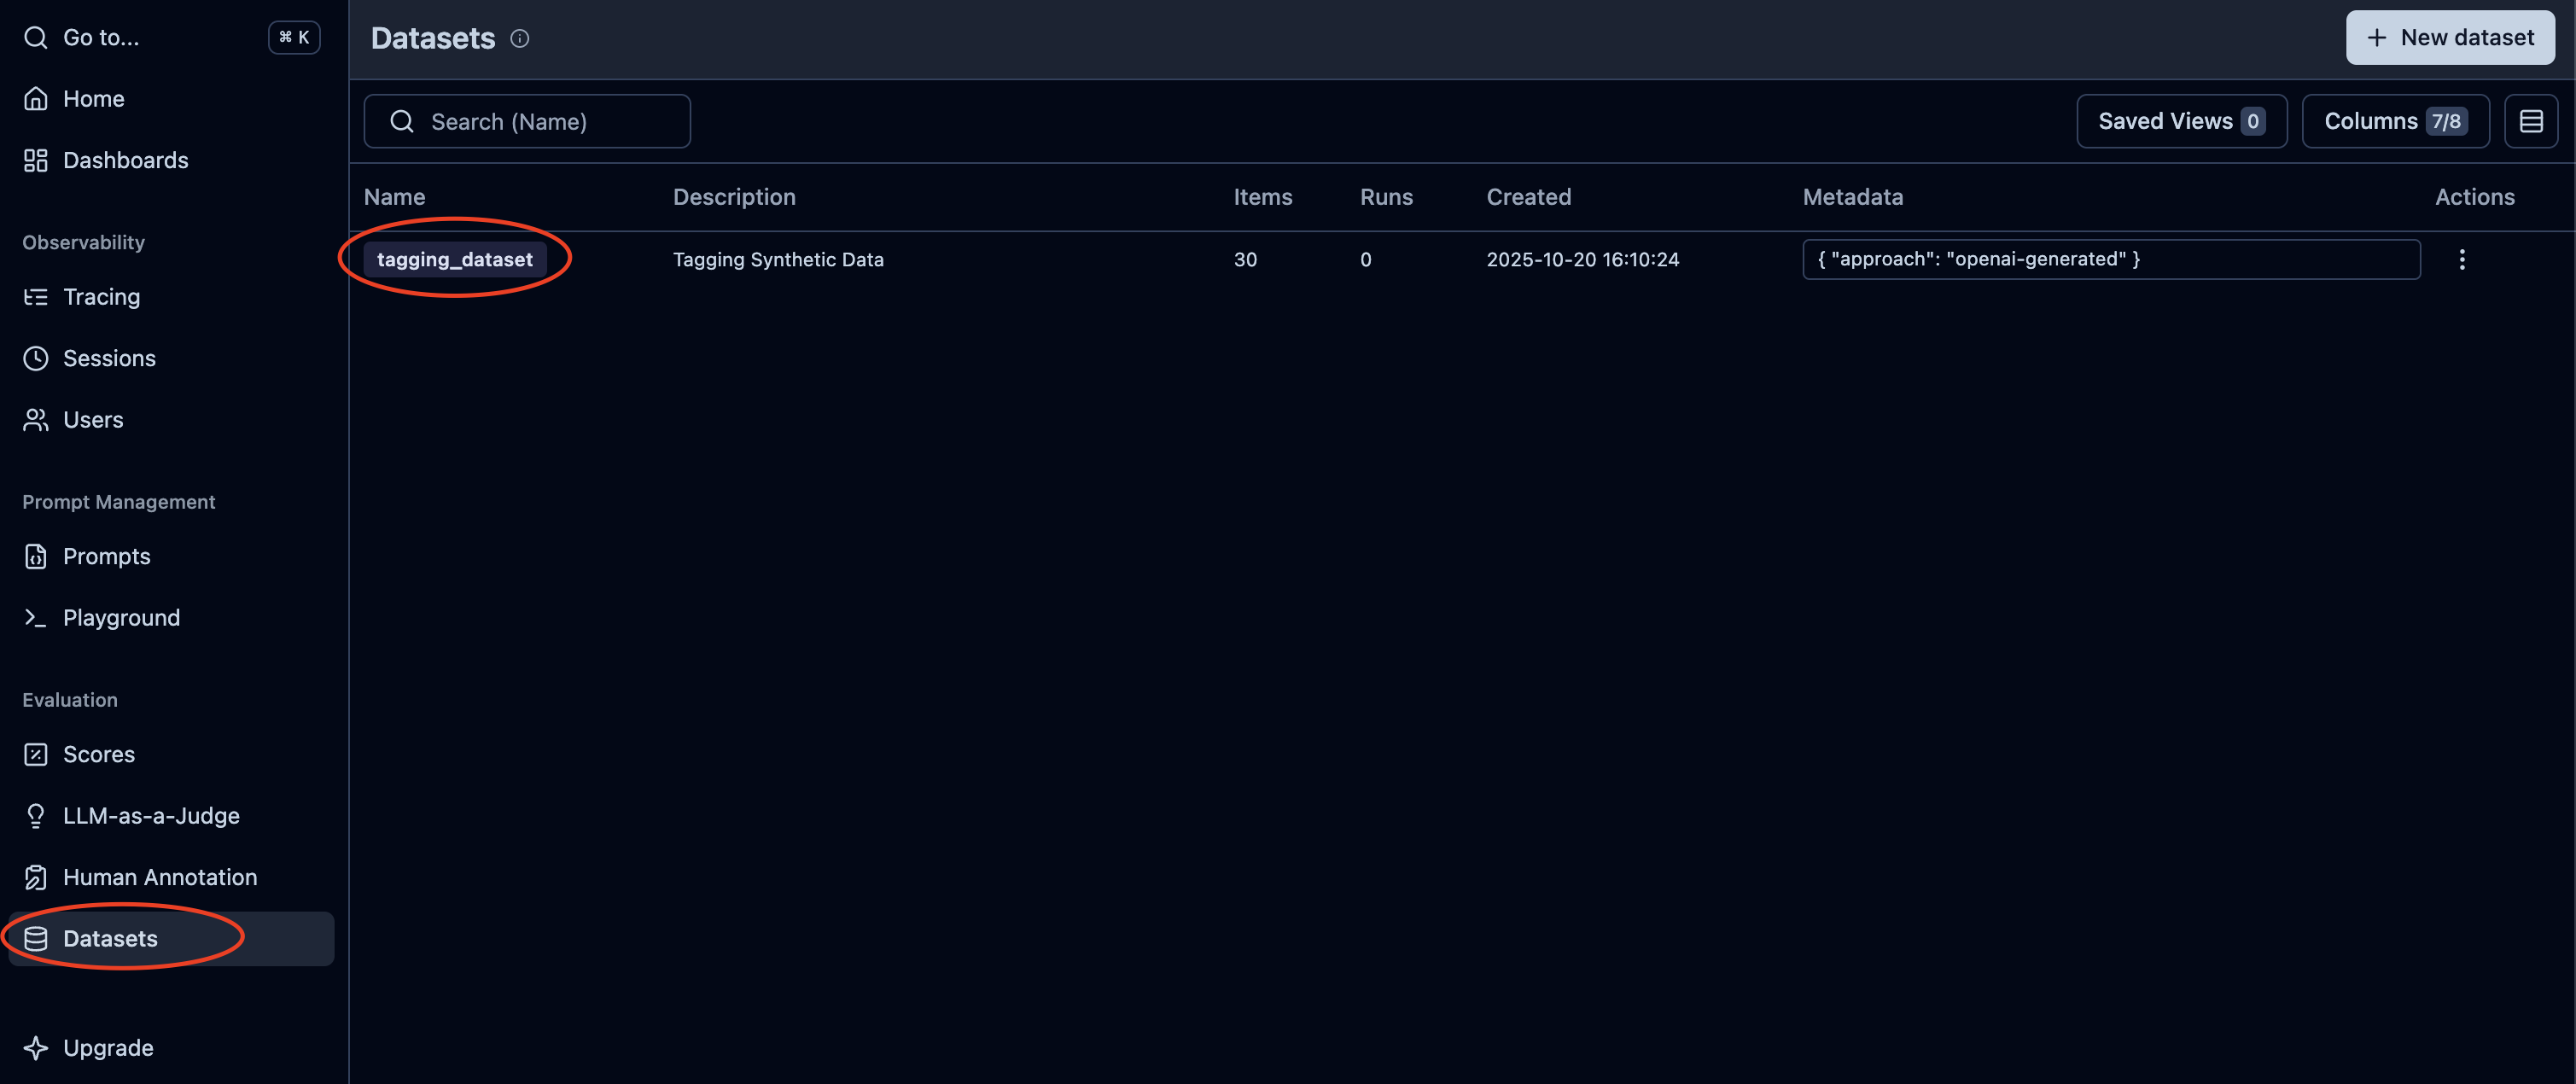

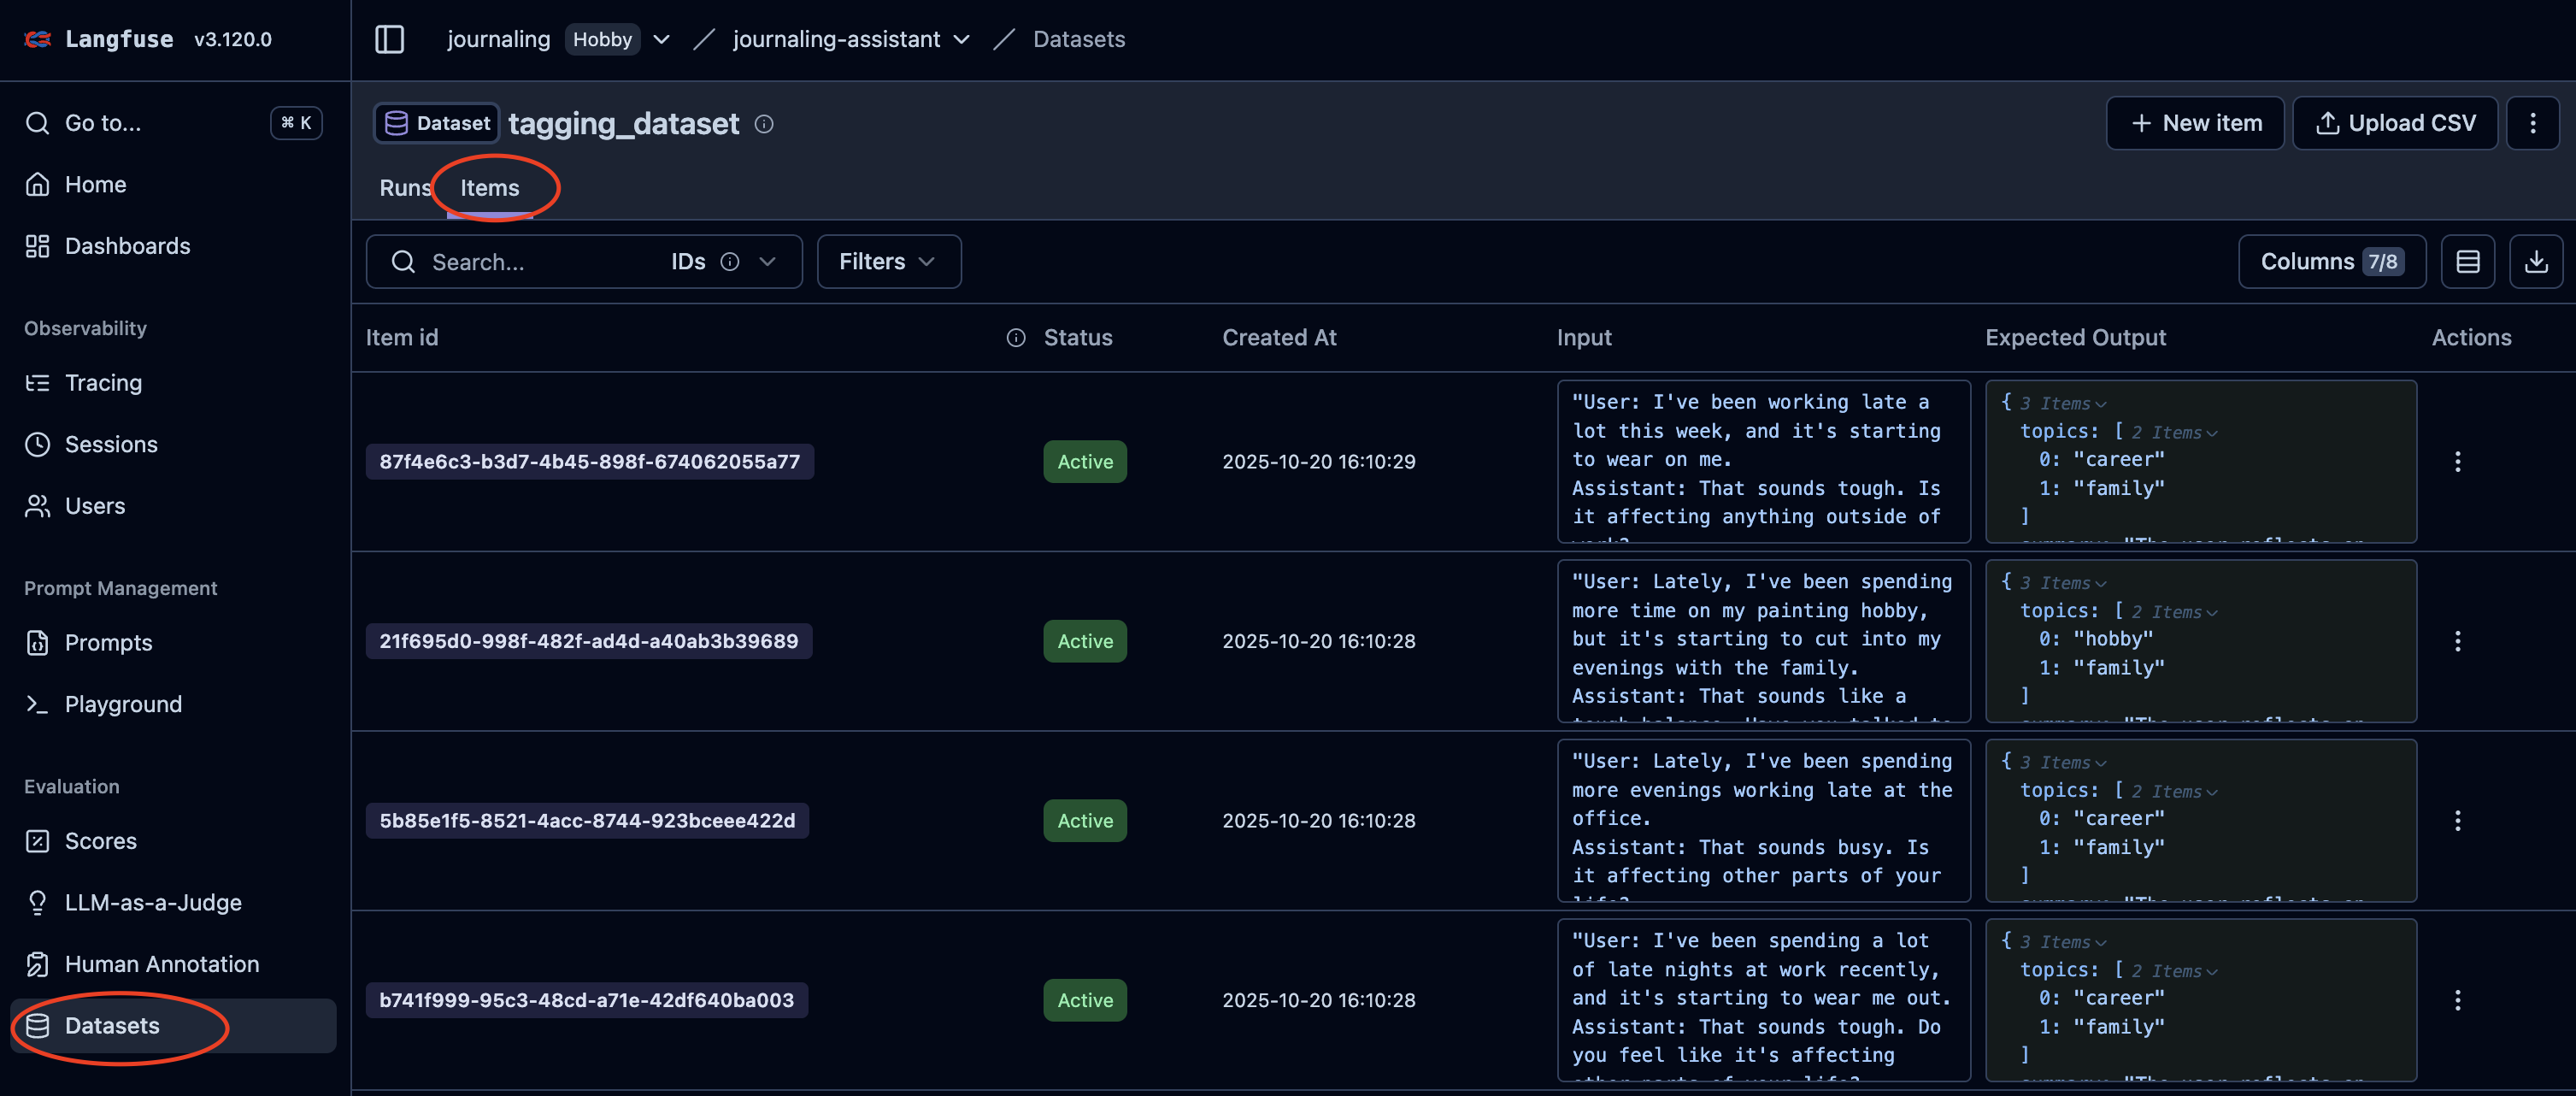

## Variants & Metrics

For the experiment part, I want to compare two structured data extraction approaches and two different models.

###Approaches

- **Instruction-Based Prompt**: This approach relies solely on detailed instructions and examples within the system prompt to guide the model. It's a universal method that should work with almost any LLM, making. It a good baseline if using models without advanced features.
- **Schema-Enforced Prompt**: This approach uses the model's tool/function calling feature to ensure the output follows the JSON structure, but keep in mind this capability isn't supported by all models or APIs (unlike the instruction-based method).

📝 Note: You might notice that I used the `response_format={"type": "json_object"}` parameter when generating the synthetic dataset earlier. That is simply to ensure that "expected output" examples are JSON. However, for the experiment itself, I am intentionally not using it. My goal is to compare how well the prompting strategies alone perform, as relying on a specific feature like OpenAI's JSON mode feels too narrow and less applicable across different models or APIs.

###Models
- `gpt-4o-mini`: fast and cost-effectiveness.
- `gpt-4o`: state-of-the-art reasoning, known for good instruction-following capabilities.

###Metrics
To determine the "best" variant, I need measurable criteria. So, I thought of several evaluation metrics:
- `is_valid` (Rule-Based): This is the most basic requirement. If the output isn't valid JSON, the application can't parse it, making the entire response useless programmatically (well, requering additional validation for an output). Here I use strict pass/fail scores (0 or 1).
- `topics_correctness_regex` (Rule-Based): I want to know if the model correctly identifies the topics from predefined list (["career", "hobby", "family", "health", "friends"]). Using regex allows to check this even if the JSON structure is broken. Here I also use 0 or 1 score.
- `summary_quality` (LLM-as-a-Judge): Evaluating the summary's quality is subjective, so for that I am using LLM-as-a-judge. With the score from 0 to 1.
- `average_score`: average result of rule-based and LLM evaluators.
- cost and latency (Tracked Automatically): Langfuse automatically tracks these (so, why not using, right?).

Now with the experimental setup done, let's implement the code for the different approaches and evaluators.


## Instruction-based Approach

The first approach relies on providing detailed instructions and a clear example within the  system prompt.

In [4]:
instruction_based_prompt = f"""
You are an AI assistant specializing in analyzing journal entries. Your task is to read a short conversation representing a journal entry and extract specific information into a single, clean JSON object. Your response MUST be ONLY the JSON object, with no extra text, explanations, or markdown formatting.

Here is an example of the task:

**Input Conversation Example:**

User: Feeling really good after my run this morning.
Assistant: That's great! Did you try a new route?
User: No, just the usual park loop, but I finally beat my personal best time!

**Output JSON:**
```json
{{
  "topics": ["health"],
  "sentiment": "Positive",
  "summary": "User reflects on feeling good after achieving a personal best during their morning run."
}}


**Important Rules:**

Extract the following fields: topics (list of strings), sentiment (string), summary (string).
    - topics: Choose one or more relevant topics exclusively from this predefined list: ["career", "hobby", "family", "health", "friends"]. Base this on the main themes of the whole conversation.
    - sentiment: Must be exactly one of "Positive", "Negative", or "Neutral". Choose the overall dominant sentiment of the conversation.
    - summary: A concise (1-2 sentence) summary of the entire conversation's main point or reflection.

If any piece of information cannot be reliably determined, use null for strings or an empty list [] for topics.

Your entire response must be only the valid JSON object. Do not wrap the JSON in a markdown block!
"""

Next, I create the Python function that will take a dataset item and call the specified LLM model using the `instruction_based_prompt` defined above. I also decorate this function with `@observe` to automatically trace its execution in Langfuse.

In [5]:
from langfuse import get_client
from langfuse.openai import OpenAI
from langfuse import observe


langfuse = get_client()

# For tracing
@observe(name="instruction-based-approach")
async def journal_tagging(*, item, model, client, **kwargs):
  # Here I am checking the type because Langfuse expects DatasetItemClient,
  # but for test I am parsing a simple dict.
  if isinstance(item, dict):
    request = item["input"]
  else:
    request = item.input

  response = await client.chat.completions.create(
    model=model,
    messages=[
      {"role": "system", "content": instruction_based_prompt},
      {"role": "user", "content": request}
    ]
  )

  return response.choices[0].message.content

Lets try calling created function to make sure the app works and traces are created.

In [ ]:
item = {
    "input": "Test!"
}
client = OpenAI()
await journal_tagging(item=item, client=client, model='gpt-4o')

Amazing, trace was created!

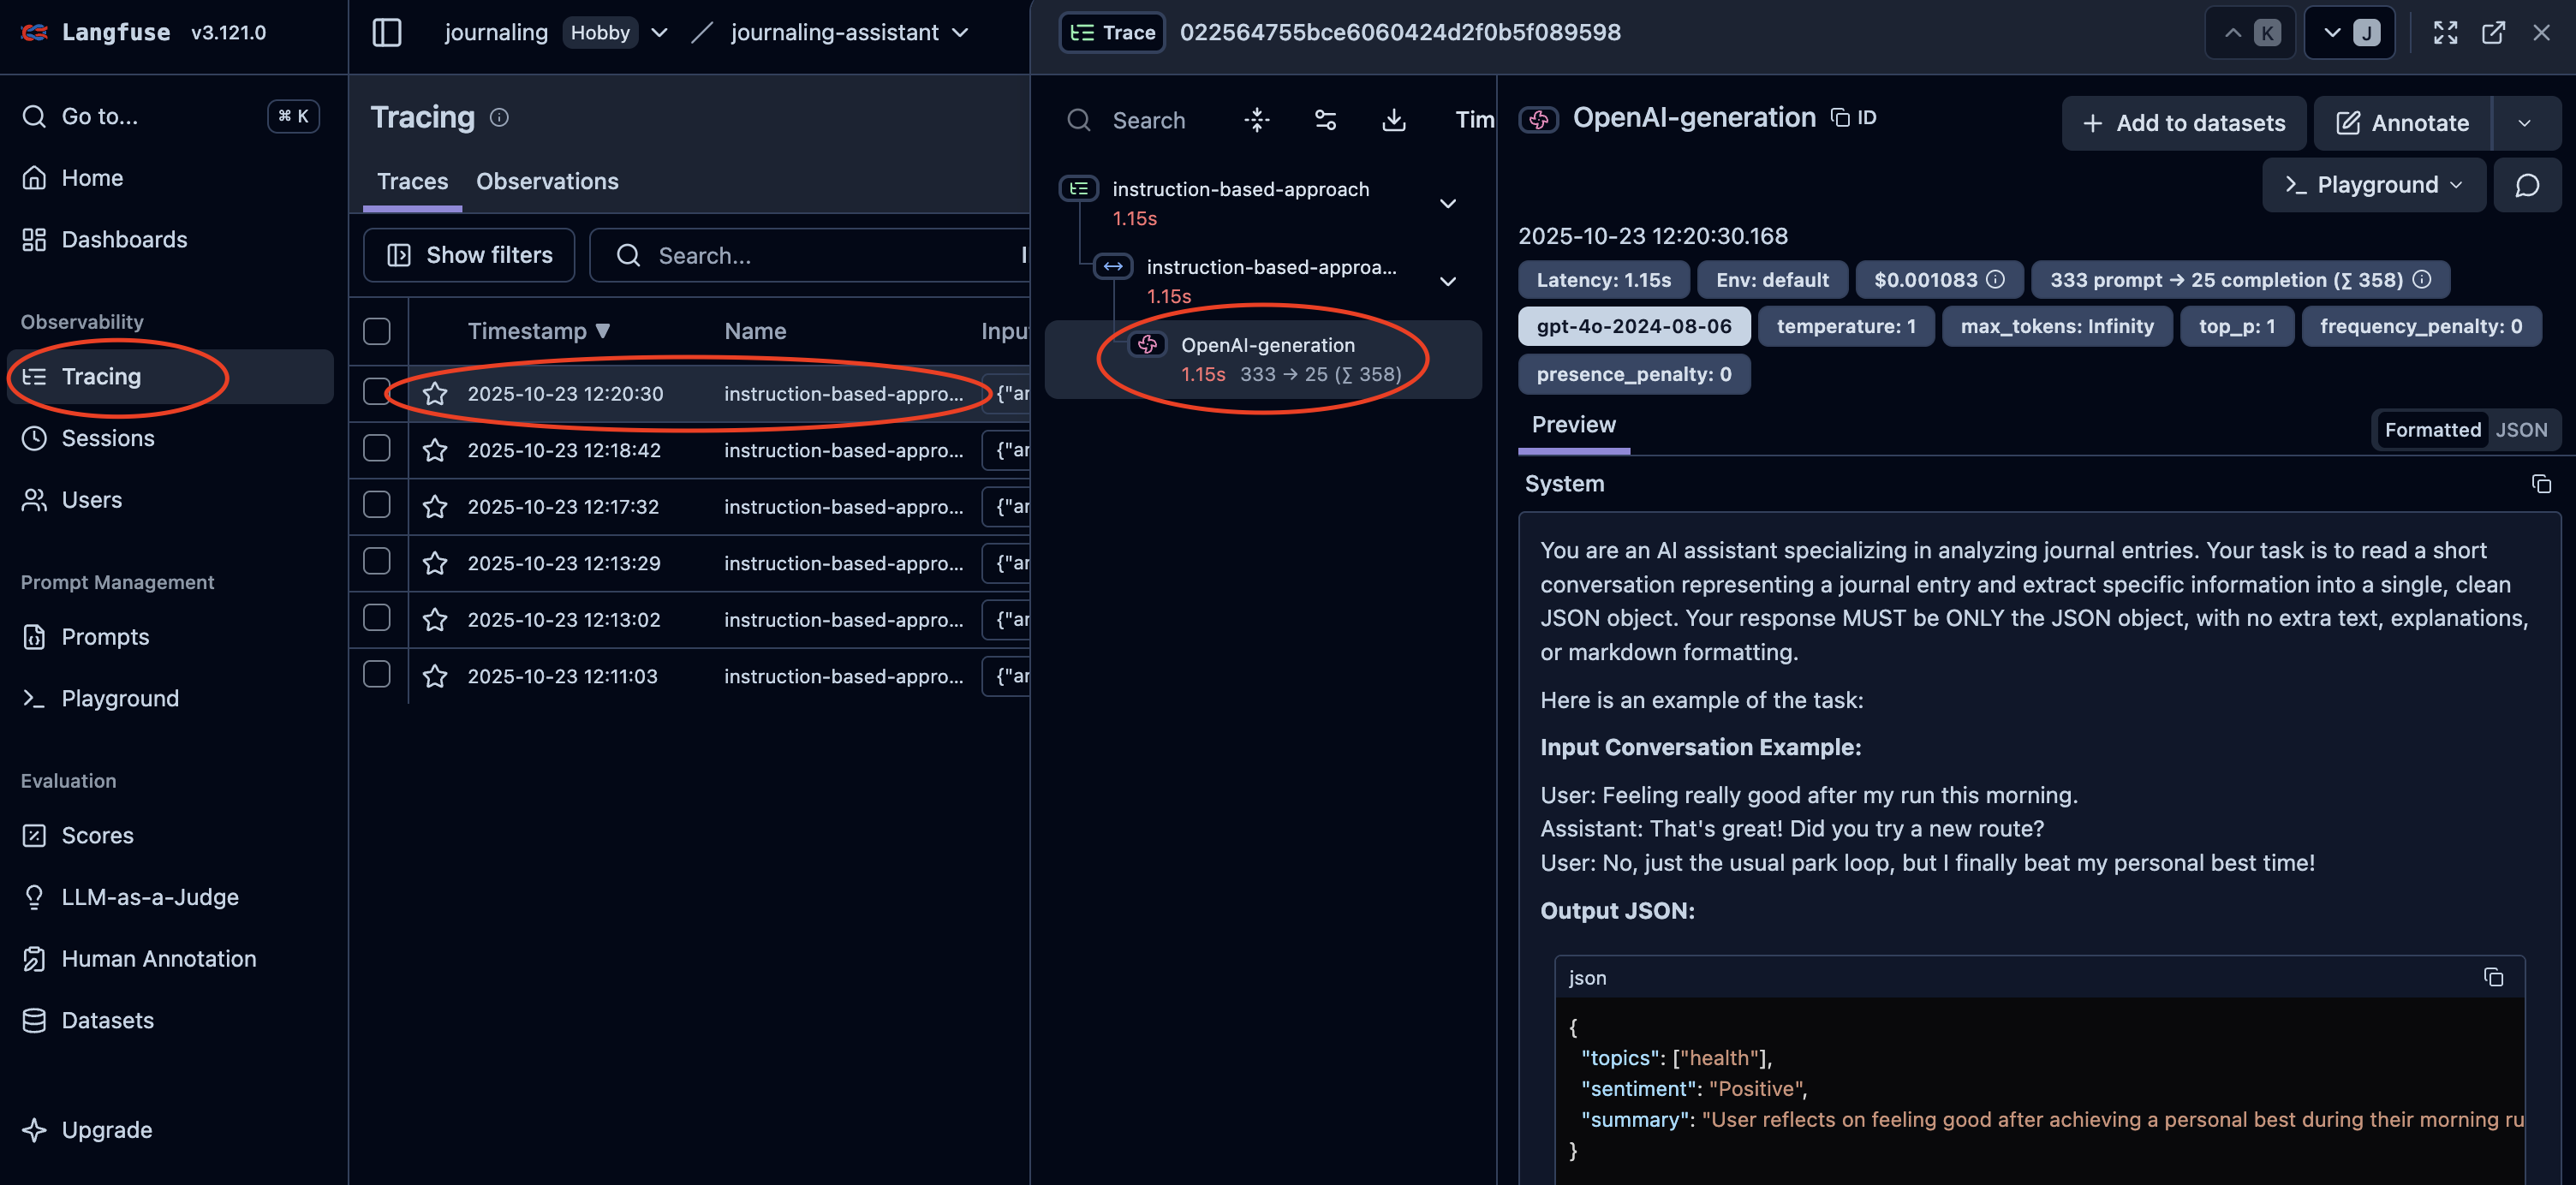

Great! Next, I'll implement the schema approach.

## Schema-enforced Approach
The second approach uses the LLM's specific tool/function calling feature. Instead of relying solely on instructions in the prompt, we provide a structured schema that defines the exact JSON output we expect. The model is then instructed (or forced) to generate data corresponding to this schema. This method often leads to more reliable and syntactically correct JSON.

Since the schema itself will contain detailed instructions for the output, the system prompt can be very simple. Its main job is to set the context and tell the model to use the provided tool.

In [6]:
schema_enforced_prompt = """
You are an AI assistant analyzing journal entries. Your task is to accurately
extract the topics, sentiment, and a brief summary from the user's
conversational journal entry using the provided `extract_details_schema_tool` tool.
"""

Now, let's define the tool with a name, a description, and a detailed parameters schema. This schema specifies the required fields (topics, sentiment, summary), their data types, allowed values (enum for topics and sentiment), and descriptions.

In [7]:
extract_details_schema_tool = {
    "name": "extract_details_schema_tool",
    "description": "Extracts topics, sentiment, and a summary from a conversational journal entry. If a piece of information cannot be reliably determined, set string values to null and list values to an empty list.",
    "parameters": {
        "type": "object",
        "properties": {
            "topics": {
                "type": "array",
                "items": {
                    "type": "string",
                    "enum": ["career", "hobby", "family", "health", "friends"]
                },
                "description": "A list of relevant topics discussed in the conversation, chosen exclusively from the allowed enum values."
            },
            "sentiment": {
                "type": "string",
                "enum": ["Positive", "Negative", "Neutral"],
                "description": "The overall dominant sentiment expressed throughout the conversation."
            },
            "summary": {
                "type": "string",
                "description": "A concise (1-2 sentence) summary capturing the main point or reflection of the entire conversation."
            }
        },
        "required": ["topics", "sentiment", "summary"]
    }
}

The Python function for this approach is similar to `journal_tagging`, but the API call includes `tools` parameter and the `tool_choice` parameter to force the model to use a specific tool.

In [8]:
from langfuse import observe

@observe(name="schema_tool_approach")
async def schema_tool_approach(*, item, model: str, client, **kwargs):
  if isinstance(item, dict):
    request = item["input"]
  else:
    request = item.input

  response = await client.chat.completions.create(
    model=model,
    messages=[
      {"role": "system", "content": schema_enforced_prompt},
      {"role": "user", "content": request}
    ],
    tools=[{"type": "function", "function": extract_details_schema_tool}],
    # Force the model to use the tool
    tool_choice={"type": "function", "function": {"name": "extract_details_schema_tool"}},
  )
  tool_call = response.choices[0].message.tool_calls[0]
  return tool_call.function.arguments

And lets check if `schema_tool_approach` works.

In [ ]:
item = {
  "input": "Test!"
}
client = OpenAI()
await schema_tool_approach(item=item, model='gpt-4o')

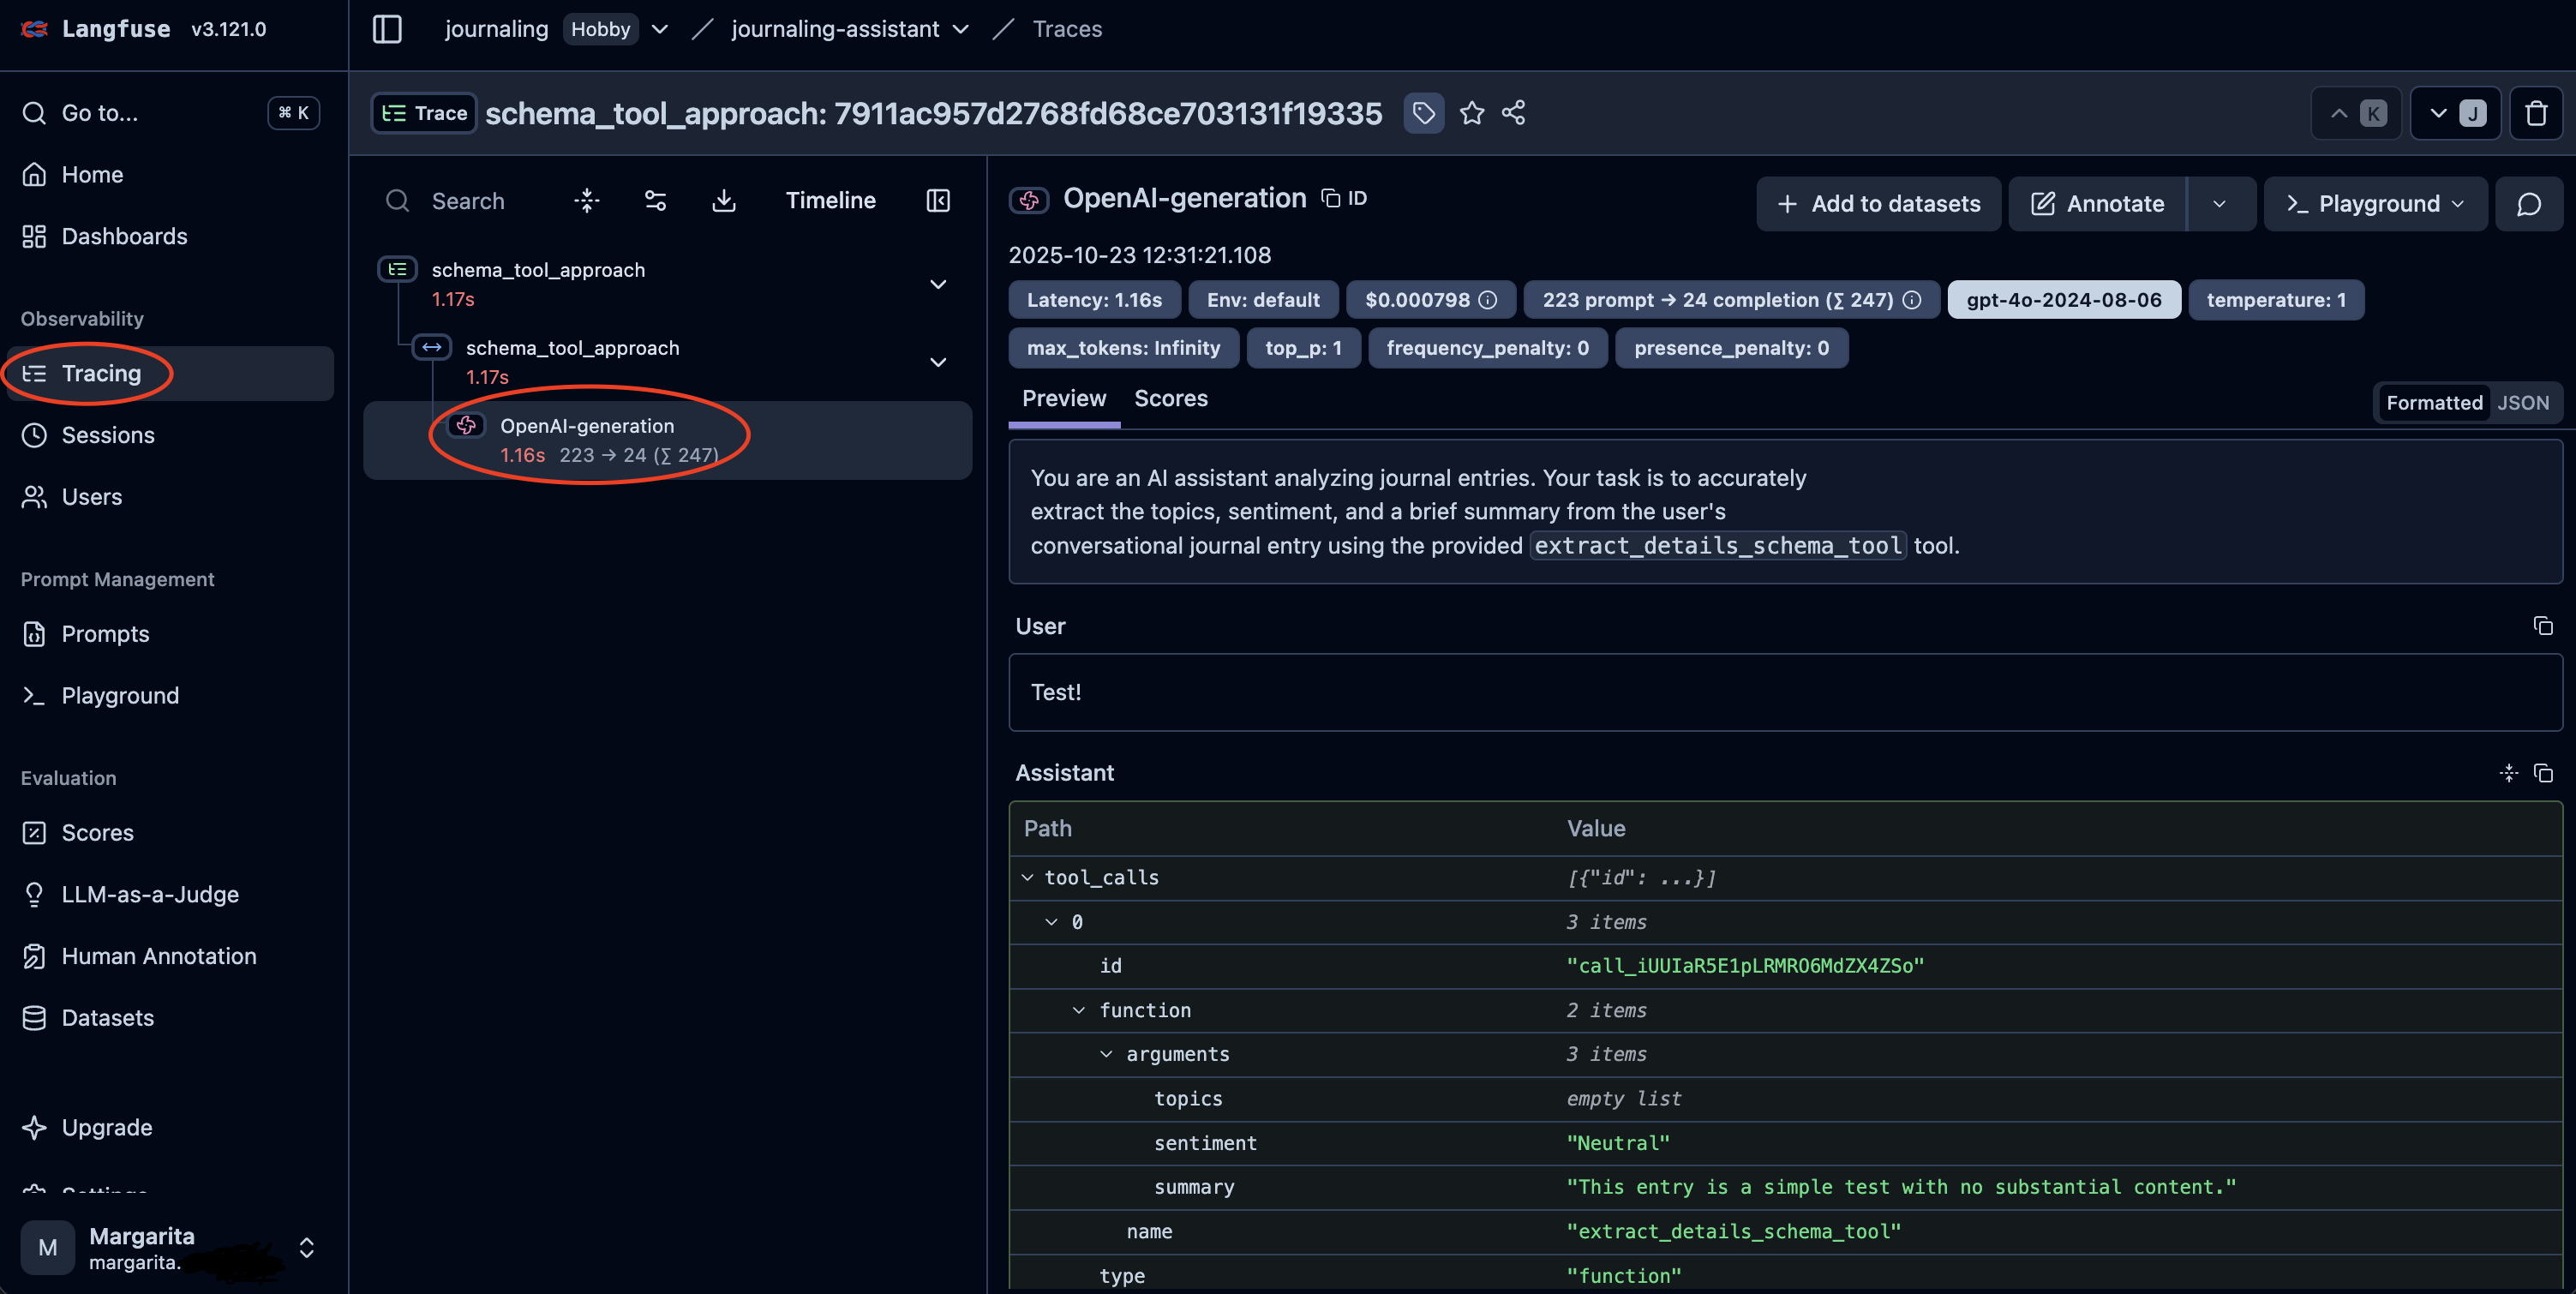

With both approaches implemented, let's move on to evaluation metrics.

## Evaluators


1. `is_valid` - this is a straightforward Python function that checks if the model's output string is a syntactically correct JSON object.

In [10]:
import json

def is_valid(*, output, **kwargs):
  try:
    json.loads(output)
    return Evaluation(name="is_valid", value=1.0, comment="Output is a valid JSON string.")
  except (json.JSONDecodeError, TypeError):
    return Evaluation(name="is_valid", value=0.0, comment="Output is NOT a valid JSON string.")

2. `topics_correctness_regex` - checks if the model correctly identified topics from the predefined list. It uses regex to scan the raw output string for the expected topics.

In [9]:
import re
from langfuse import Evaluation

def topics_correctness_regex(*, output: str, expected_output: dict, **kwargs):
  expected_topics = expected_output.get("topics", [])

  # Try to find the topics list using regex
  match = re.search(r'"topics":\s*\[(.*?)\]', output, re.IGNORECASE | re.DOTALL)
  if not match:
    return Evaluation(name="topics_correctness_regex", value=0.0, comment="Could not find 'topics' list.")

  topics_content = match.group(1)

  missing_topics = []
  for topic in expected_topics:
    # Check if the expected topic exists within the list content
    if not re.search(fr'"{re.escape(topic)}"', topics_content, re.IGNORECASE):
      missing_topics.append(topic)

  if not missing_topics:
    return Evaluation(name="topics_correctness_regex", value=1.0, comment="All expected topics found.")
  else:
    return Evaluation(
      name="topics_correctness_regex",
      value=0.0,
      comment=f"Regex search failed to find expected topics: {', '.join(missing_topics)}"
    )

3. `summary_quality_evaluator` - for this, I use LLM-as-a-Judge. I define a prompt for the judge model and a function to call it.

In [12]:
from langfuse import Evaluation
from langfuse.openai import OpenAI

client = OpenAI()

judge_system_prompt = """
You are an expert evaluator assessing the quality of an AI-generated summary for a journal entry conversation.

**Evaluation Instructions:**
Focus *only* on the `summary` field within the AI's Generated Output. Evaluate its quality on a scale of 0 to 1 based on these criteria:
1.  **Conciseness:** Is the summary brief (1-2 sentences)?
2.  **Relevance:** Does it accurately capture the main point or core reflection of the *entire* conversation?
3.  **Accuracy:** Does it correctly reflect the key details mentioned in the conversation?

Ignore any formatting issues in the overall JSON output; focus solely on the summary's content.

You MUST return a JSON object with two keys: "score" (a float from 0.0 to 1.0) and "reasoning" (a brief, one-sentence explanation for your score, focusing on the summary quality).
"""

async def summary_quality_evaluator(*, output, expected_output, input, **kwargs):
  judge_model = "gpt-4o-mini"

  judge_user_message = f"""
  **Conversation Input:**
  {input}

  **AI's Generated Output (JSON):**
  {output}
  """

  response = await client.chat.completions.create(
    model=judge_model,
    messages=[
      {"role": "system", "content": judge_system_prompt},
      {"role": "user", "content": judge_user_message}
    ],
    response_format={"type": "json_object"},
    temperature=0
  )

  result = json.loads(response.choices[0].message.content)
  score = float(result.get("score", 0))
  reasoning = result.get("reasoning", "")

  return Evaluation(
    name="summary_quality",
    value=score,
    comment=reasoning
  )

4. `average_score` - this is the run evaluator, simple function, that calculates average across all scores based on results of all above implemented evaluators.

In [13]:
def average_score(*, item_results, **kwargs):
    """Calculate average match across all items"""
    scores = [
        eval.value for result in item_results
        for eval in result.evaluations
        if eval.name == "topics_correctness_regex" or
        eval.name == "is_valid" or
        eval.name == "summary_quality"
    ]

    if not scores:
        return Evaluation(name="avg_score", value=None)

    avg = sum(scores) / len(scores)

    return Evaluation(name="avg_score", value=avg, comment=f"Average score: {avg:.2%}")


And finnaly with all evaluator functions implemented, we're ready to run the experiments!

## Implementation: Experiments

Now that we have the dataset loaded, approach functions, and evaluator functions, we can execute the experiments using the Langfuse SDK.

In [14]:
%pip install partial

  Preparing metadata (setup.py) ... done
  Created wheel for partial: filename=partial-1.0-py3-none-any.whl size=1854 sha256=3eec7b77d1f8d9ef2efc99f436bab27050a753e80260d2b6205a7f922603e212
  Stored in directory: /root/.cache/pip/wheels/b8/bc/27/5fadc3fd0c171530e02aaafef260794deb39e769890425fece
Successfully built partial


The code below loops through each model and each approach using `functools.partial` to correctly pass the parameters. Then it calls `dataset.run_experiment`, providing the task function, the list of evaluators, and the run evaluator.

In [18]:
from functools import partial
from langfuse import get_client

langfuse = get_client()

dataset = langfuse.get_dataset("tagging_dataset")

models = ["gpt-4o", "gpt-4o-mini"]

client = OpenAI()

for model in models:
  task_with_args = partial(
      journal_tagging,
      model=model,
      client=client,
  )

  result = dataset.run_experiment(
      name=f"Instruction Based - {model}",
      description="Journal Tagging Experiment",
      task=task_with_args,
      evaluators=[topics_correctness_regex, is_valid, summary_quality_evaluator],
      run_evaluators=[average_score],
      metadata={'model': model}
  )

  print(result.format())

Individual Results: Hidden (30 items)\n💡 Set include_item_results=True to view them\n\n──────────────────────────────────────────────────\n🧪 Experiment: Instruction Based - gpt-4o
📋 Run name: Instruction Based - gpt-4o - 2025-10-27T11:05:05.457107Z - Journal Tagging Experiment\n30 items\nEvaluations:\n  • summary_quality\n  • topics_correctness_regex\n  • is_valid\n\nAverage Scores:\n  • summary_quality: 0.940\n  • topics_correctness_regex: 0.967\n  • is_valid: 0.867\n\nRun Evaluations:\n  • avg_score: 0.924\n    💭 Average score: 92.44%\n\n🔗 Dataset Run:\n   https://cloud.langfuse.com/project/cmfjndxl700y6ad06ahhcd6d7/datasets/cmgz7q87900i4ad07hqji2p4k/runs/57c51c48-735e-46c9-bbaf-1be001339841
Individual Results: Hidden (30 items)\n💡 Set include_item_results=True to view them\n\n──────────────────────────────────────────────────\n🧪 Experiment: Instruction Based - gpt-4o-mini
📋 Run name: Instruction Based - gpt-4o-mini - 2025-10-27T11:05:15.056199Z - Journal Tagging Experiment\n30 items

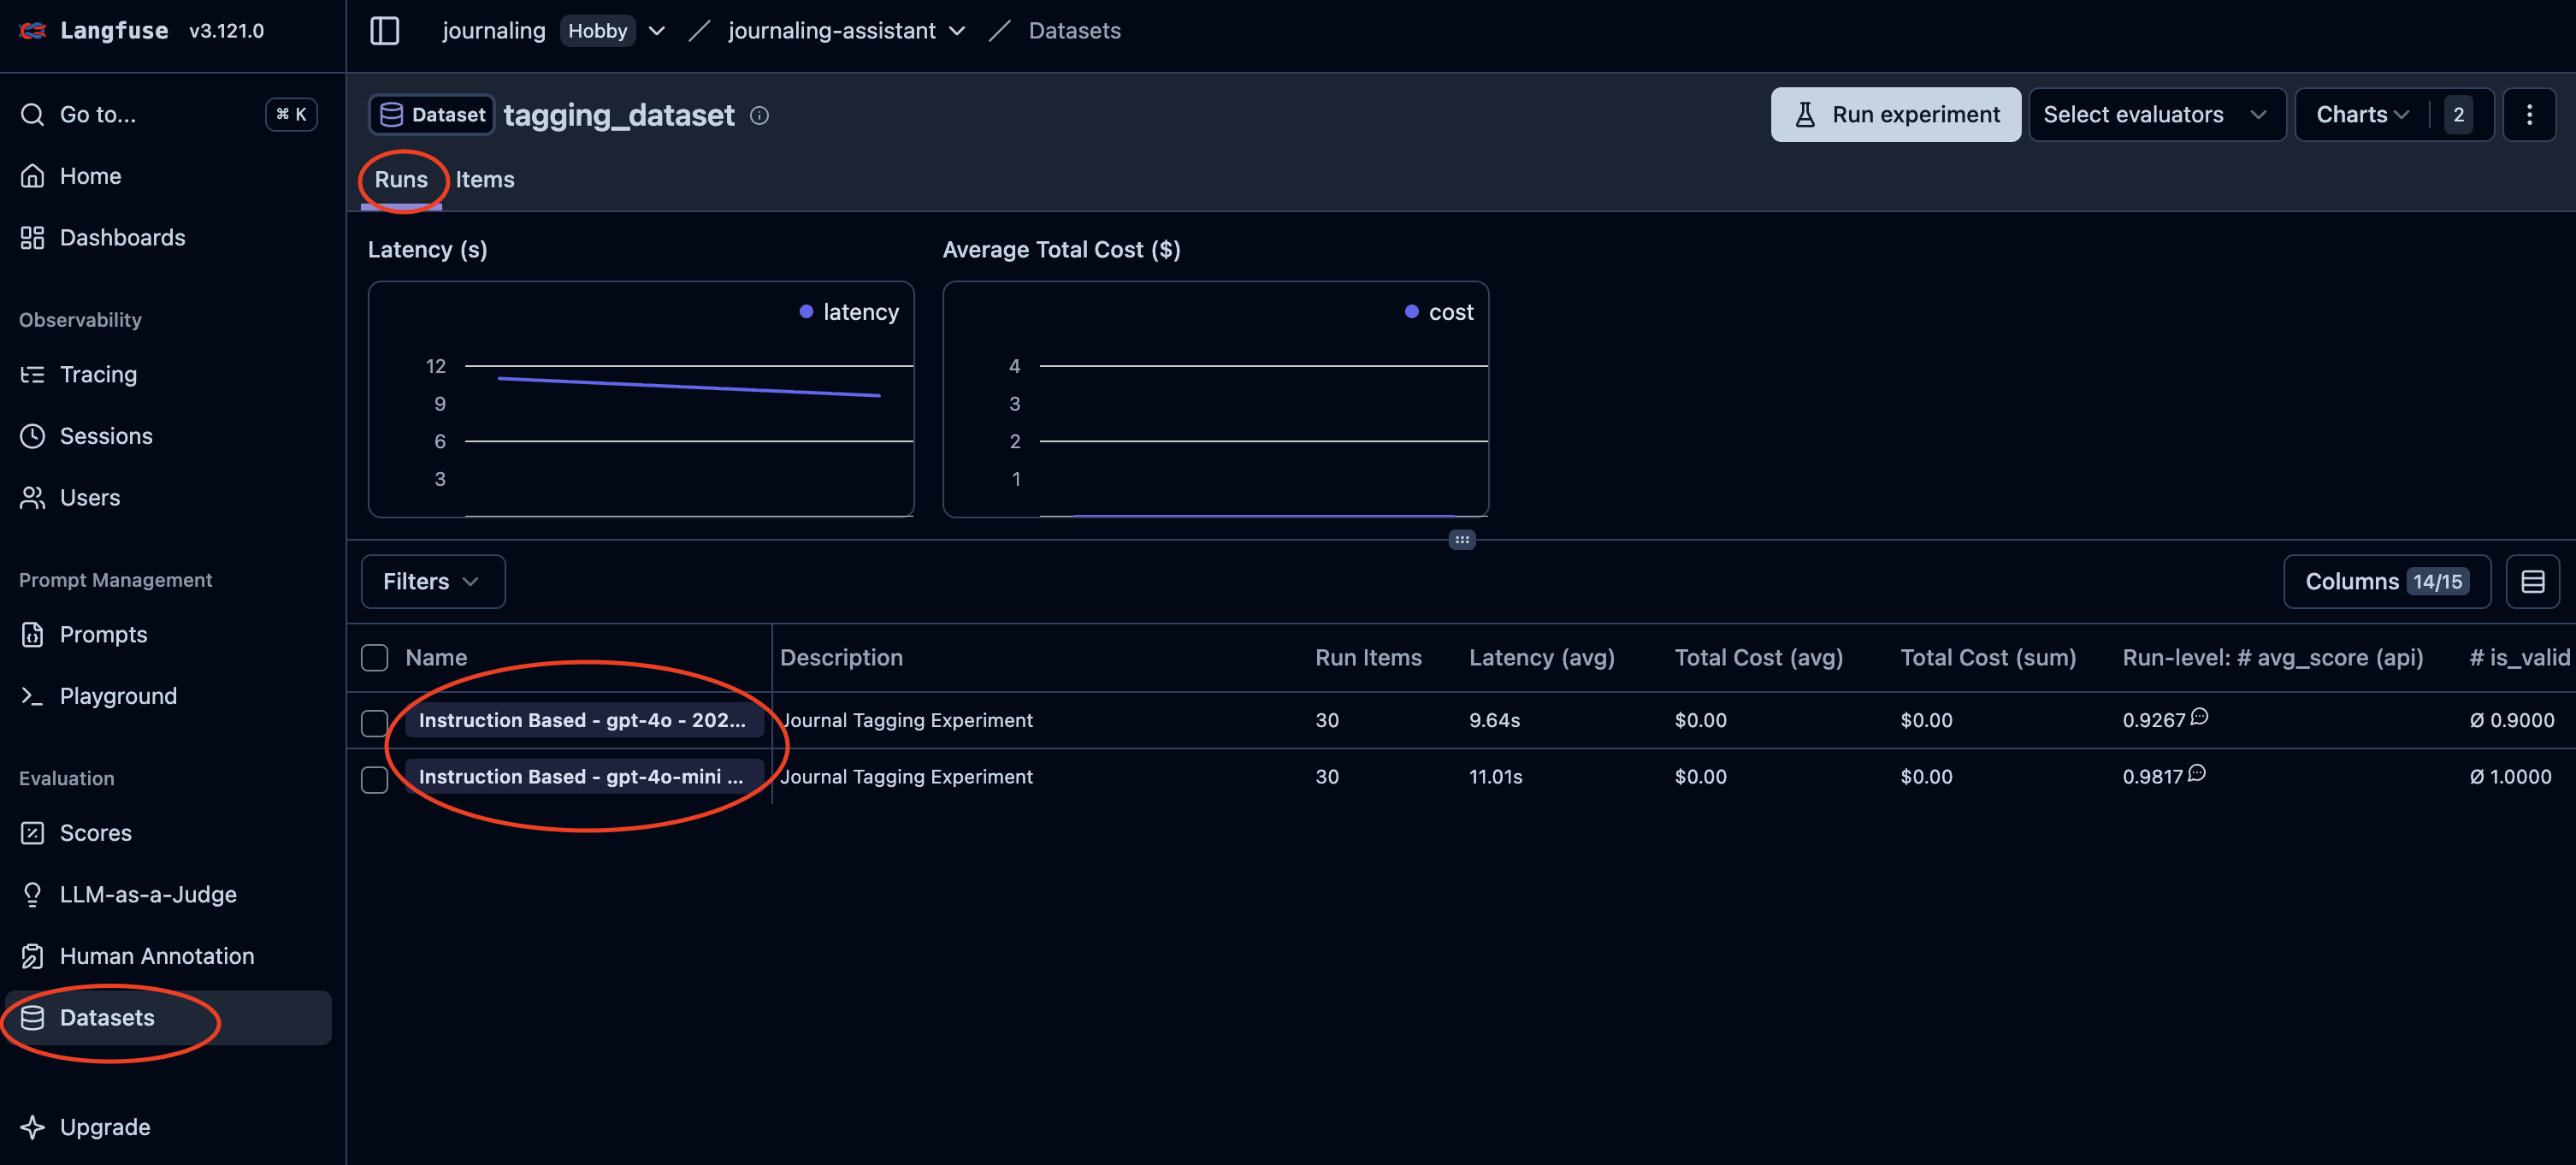

And for the schema approach I implement a similar code.

In [20]:
from functools import partial

dataset = langfuse.get_dataset("tagging_dataset")

models = ["gpt-4o", "gpt-4o-mini"]

client = OpenAI()

for model in models:
  task_with_args = partial(
      schema_tool_approach,
      model=model,
      client=client,
  )

  schema_call_result = dataset.run_experiment(
      name=f"Schema-enforced Approach - {model}",
      description="Journal Tagging Experiment",
      task=task_with_args,
      evaluators=[topics_correctness_regex, is_valid, summary_quality_evaluator],
      run_evaluators=[average_score],
      metadata={'model': model}
  )

print(schema_call_result.format())

Individual Results: Hidden (30 items)\n💡 Set include_item_results=True to view them\n\n──────────────────────────────────────────────────\n🧪 Experiment: Schema-inforsed Approach - gpt-4o-mini
📋 Run name: Schema-inforsed Approach - gpt-4o-mini - 2025-10-27T11:06:45.362642Z - Journal Tagging Experiment\n30 items\nEvaluations:\n  • summary_quality\n  • topics_correctness_regex\n  • is_valid\n\nAverage Scores:\n  • summary_quality: 0.967\n  • topics_correctness_regex: 0.967\n  • is_valid: 1.000\n\nRun Evaluations:\n  • avg_score: 0.978\n    💭 Average score: 97.78%\n\n🔗 Dataset Run:\n   https://cloud.langfuse.com/project/cmfjndxl700y6ad06ahhcd6d7/datasets/cmgz7q87900i4ad07hqji2p4k/runs/b41c4a26-2efd-4a9f-a196-4364f49676e7


Here how results look like in Langfuse.

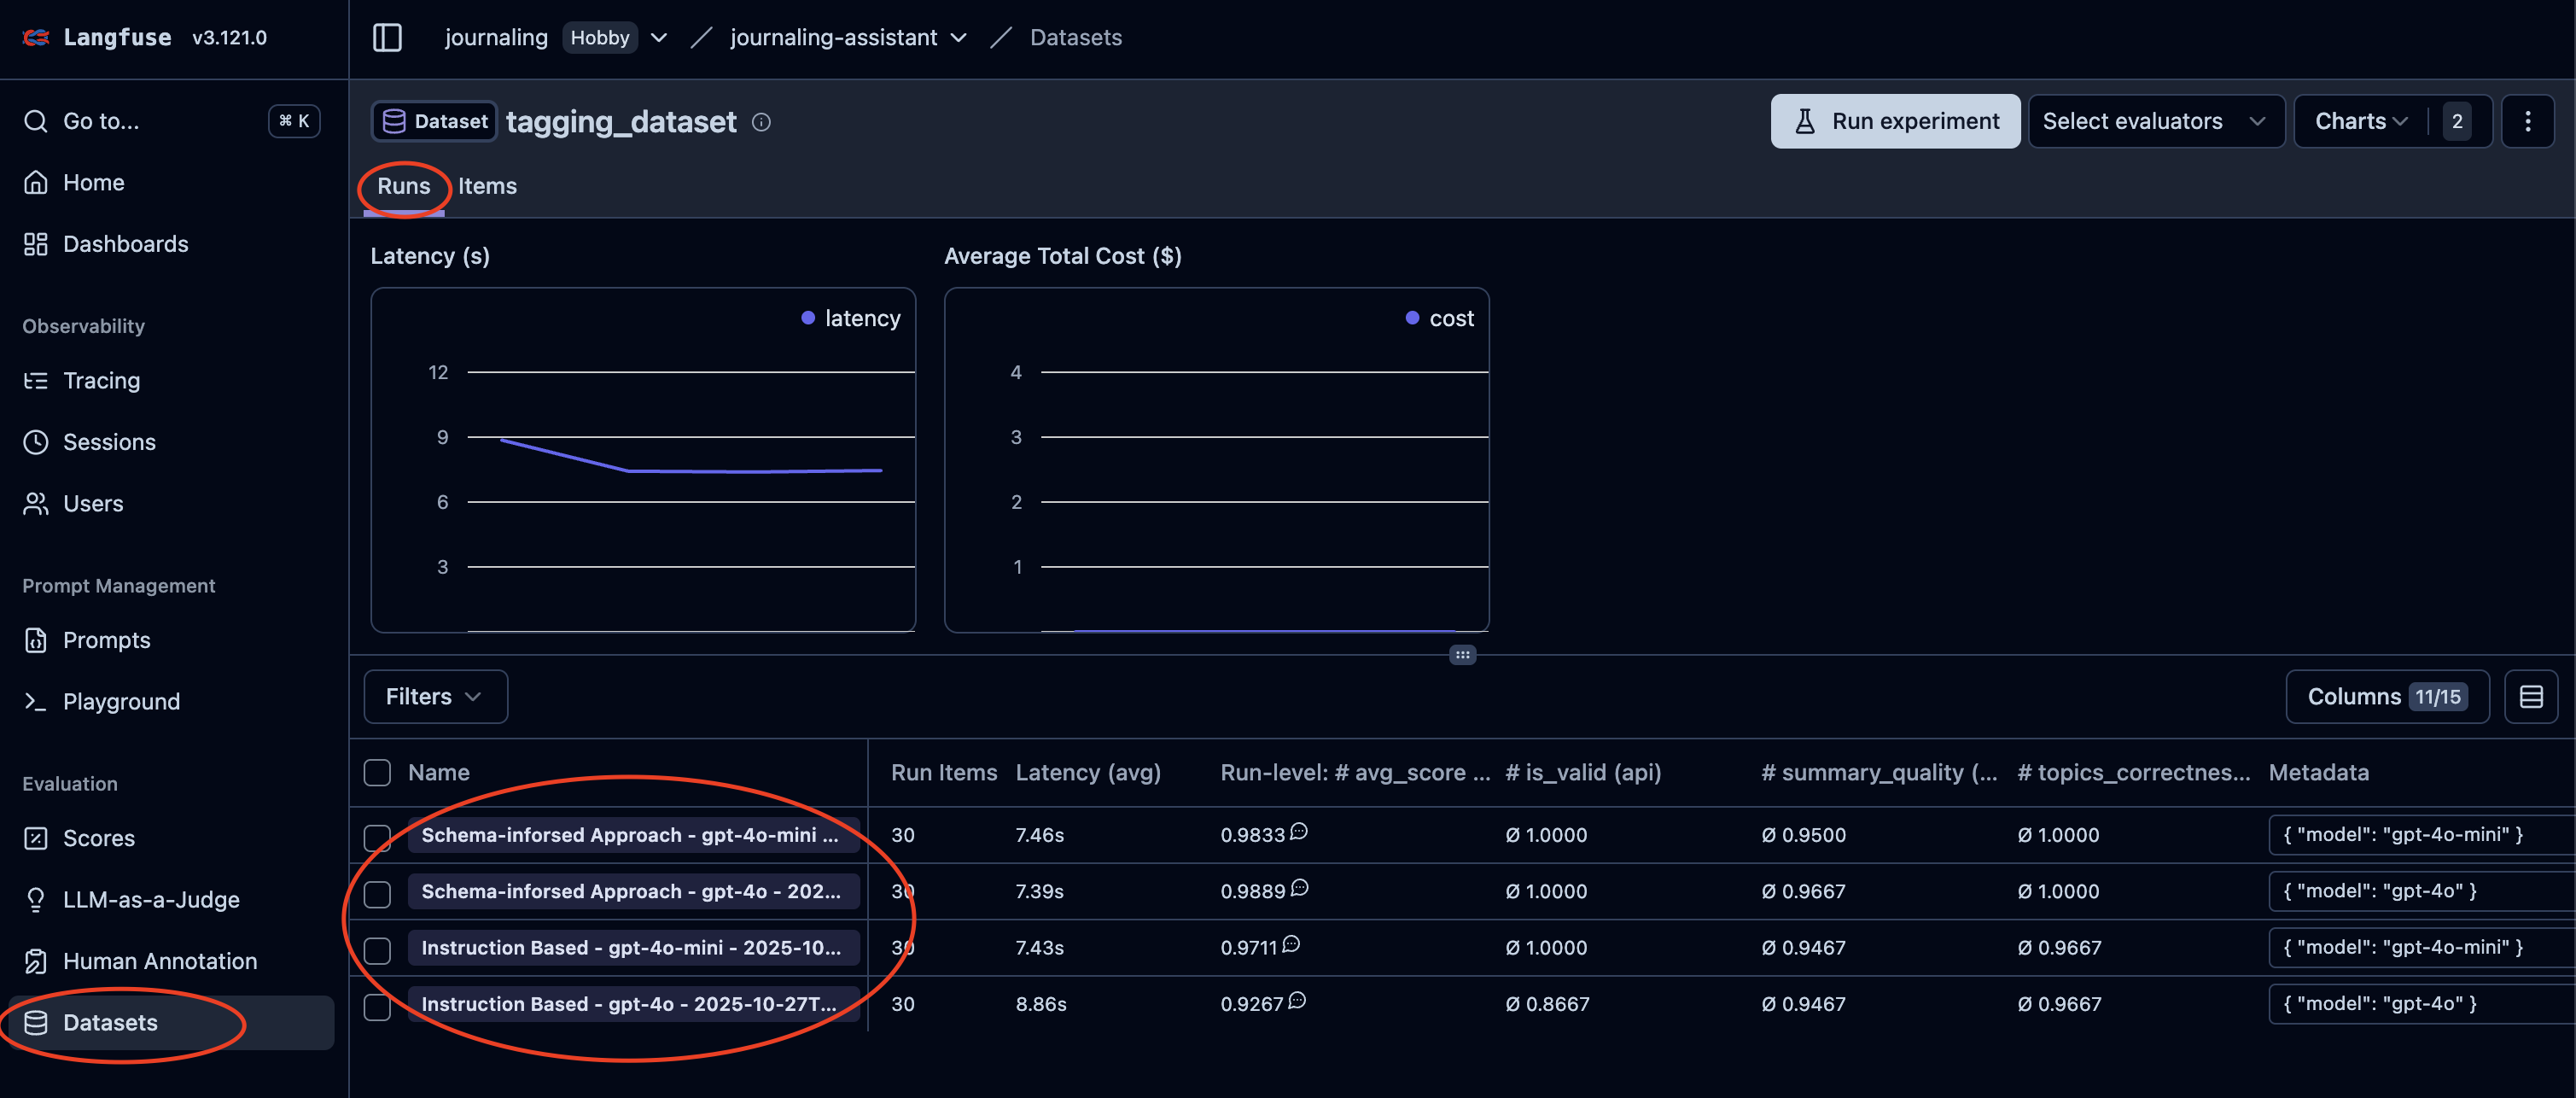

*yes, I know there is a typo on a screenshot... I noticed that too late and did not want to rerun everything and make new screenshots, sorry :(*


# Analysis
With the experiments complete, it's time to dig into the data. Langfuse provides several views, but let's start with the charts for a high-level overview before diving deeper.

### Chart Overview

- Latency: All variants performed similarly, averaging between 7 and 9 seconds per run. No major differences here.
- Costs: Showed as 0 in the UI for these models. (Note: Langfuse might not display very low costs in the dataset section currently).
- Quality Scores (`summary_quality`, `topics_correctness`): Generally high (close to 1.0) across the board, suggesting all approaches are reasonably effective.
- JSON Validity (`is_valid`): This metric shows the most variation, with one variant dipping below 1.0, indicating potential formatting issues.

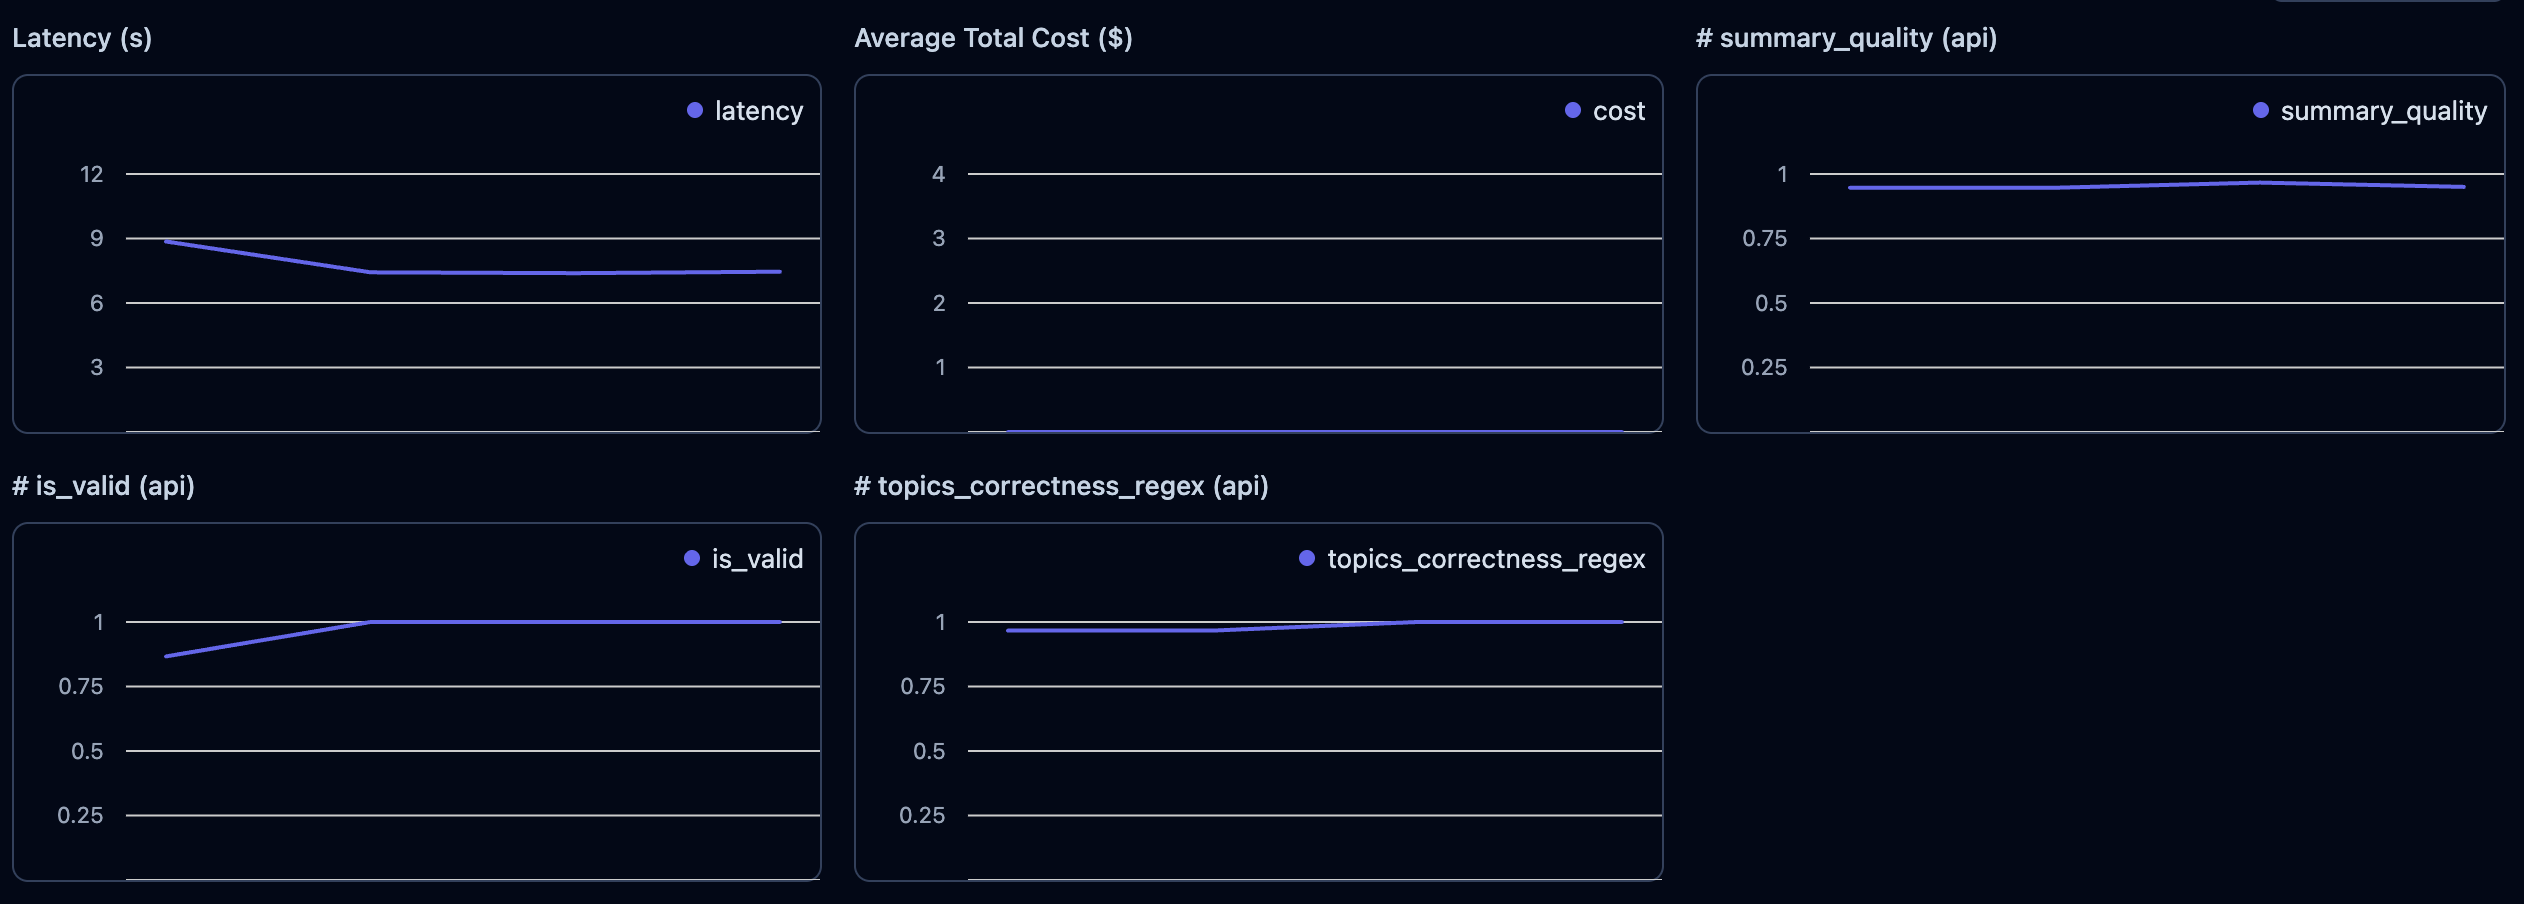

Ok, now when I know the general tendencies, lets look in detail. Let's see where models make mistakes.

### Where Do Models Make Mistakes?

After looking closely at individual runs I noticed these mistakes:
- Markdown Issues: The instruction-based `gpt-4o` sometimes wrapps its output in markdown (e.g., json ... ), causing the `is_valid_json` check to fail. While this could potentially be cleaned programmatically, it's an extra step I'd prefer to avoid.


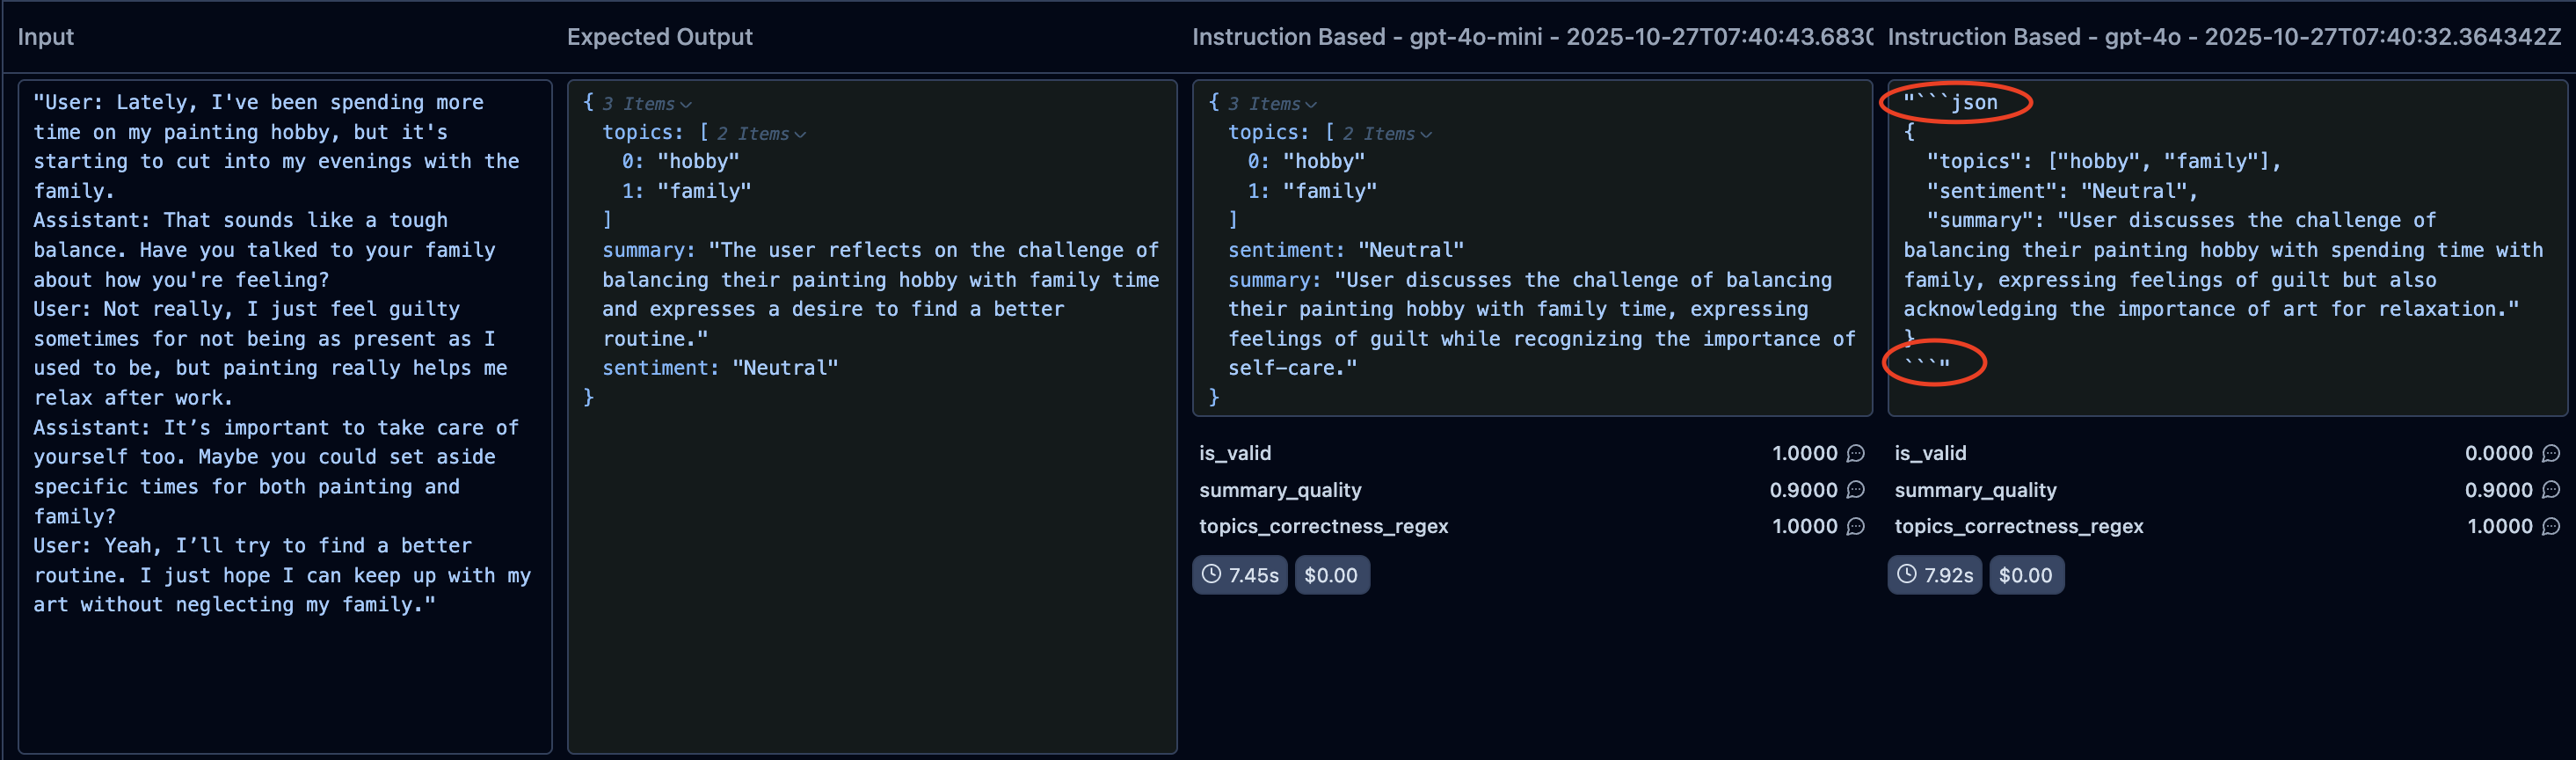

- Topic Misses: The instruction-based `gpt-4o-mini`, while generally strong, occasionally missed secondary topics in more complex conversations compared to the schema approach.

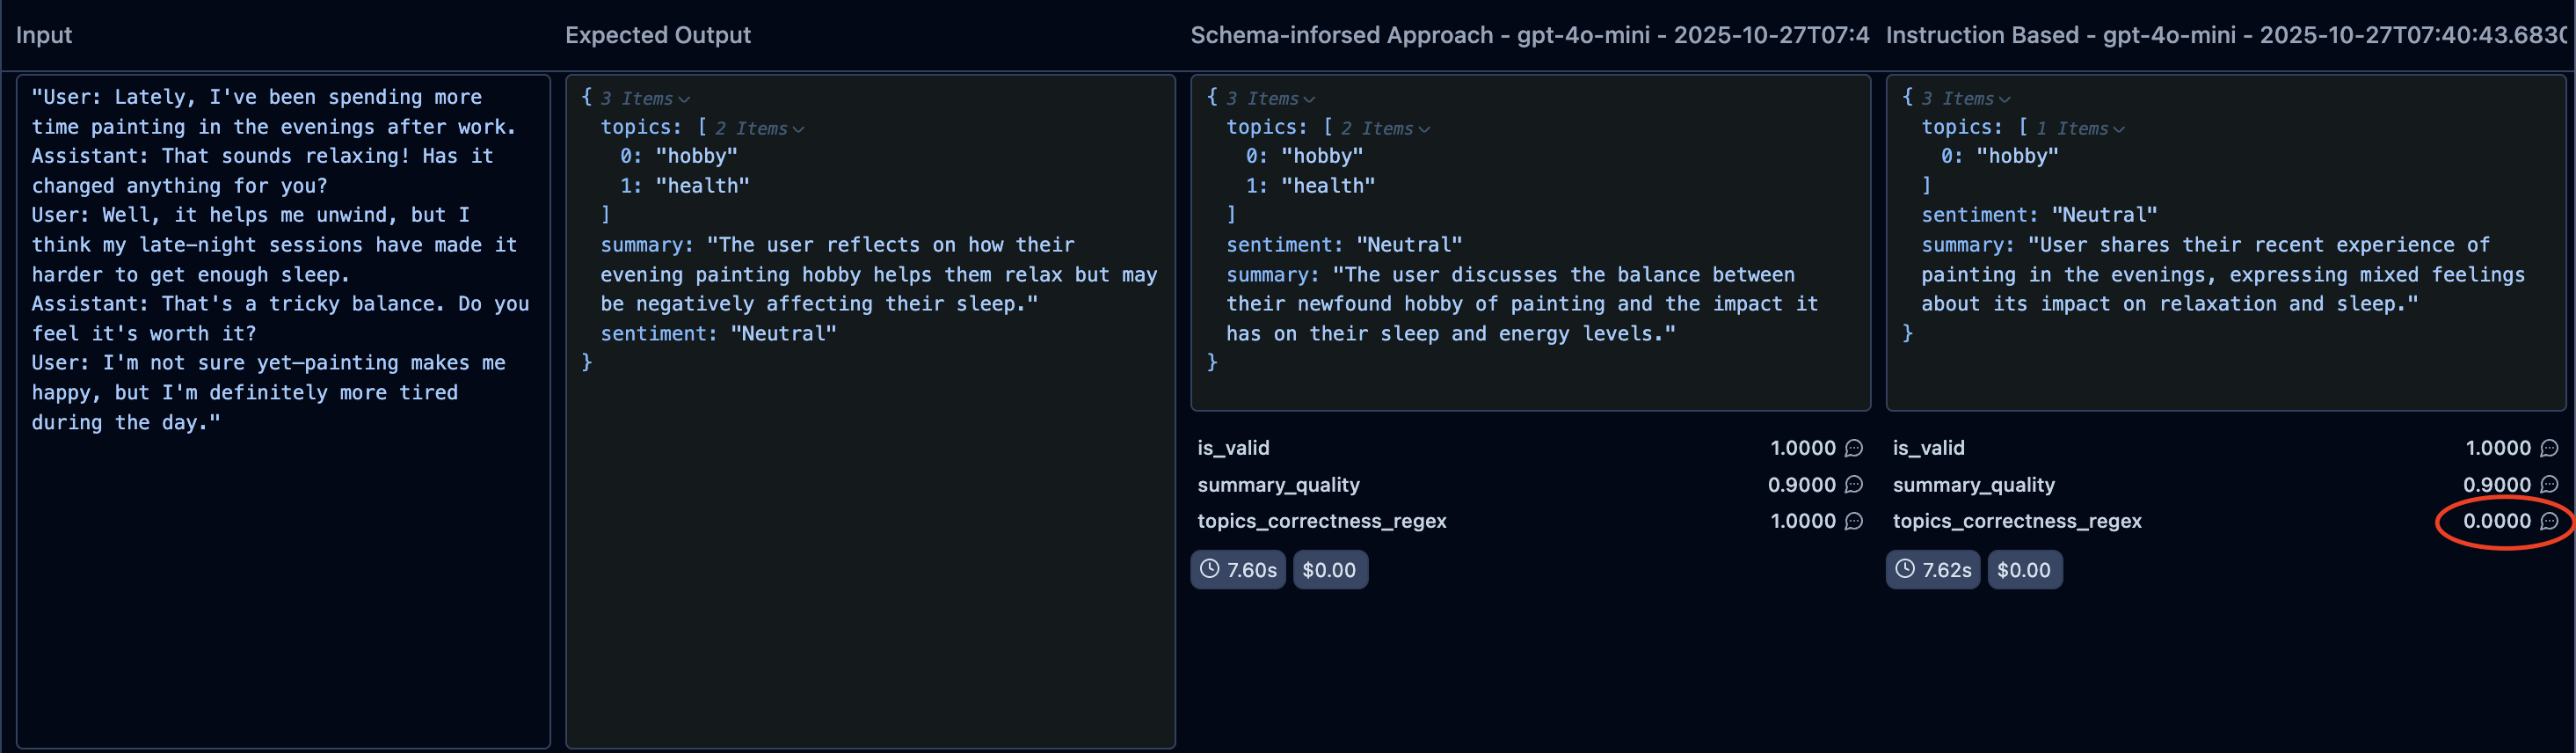

- Picky Judge? My `summary_quality` LLM-as-a-Judge seems a bit harsh, sometimes scoring good summaries as 0.8. I guess, the judge's prompt itself should be refined...

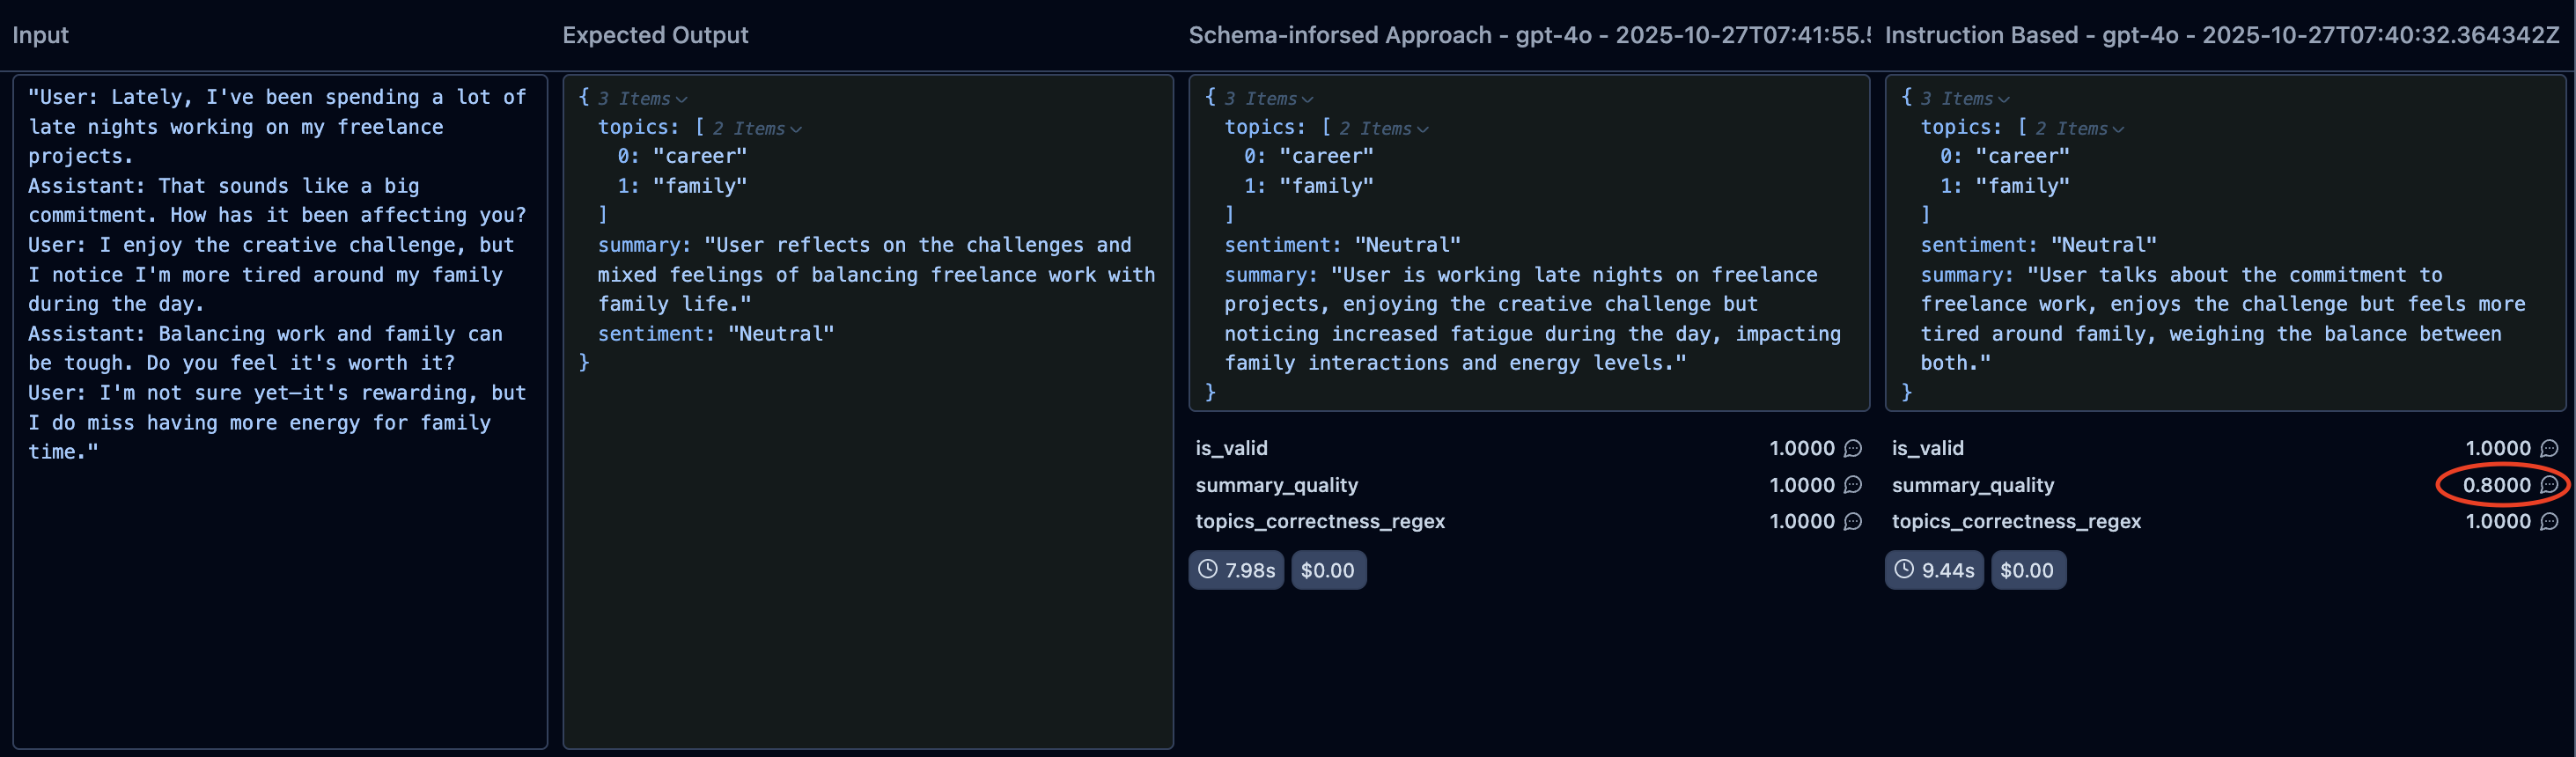

### Overall Results of The First Run

Looking at the results from a single execution:

- **Latency:** The instruction-based `gpt-4o` is the slowest variant in this run. Interestingly, the schema-enforced `gpt-4o` is slightly faster than its `-mini` counterpart, though the differences are small.
- **JSON Validity:** The schema-enforced approach scored perfectly as expected. Surprisingly, the instruction-based `gpt-4o-mini` also achieved a perfect 1.0 score in this run, while `gpt-4o` sometimes struggled.
- **Content Quality:** `summary_quality` is fairly high across all variants. schema-enforced `gpt-4o` leads slightly.
- **Topic Cirrectness:** Both Schema approaches achieved perfect `topics_correctness` results in this run.

Based on this run, schema-enforced `gpt-4o` looks like the overall winner, closely followed by its `gpt-4o-mini` counterpart.

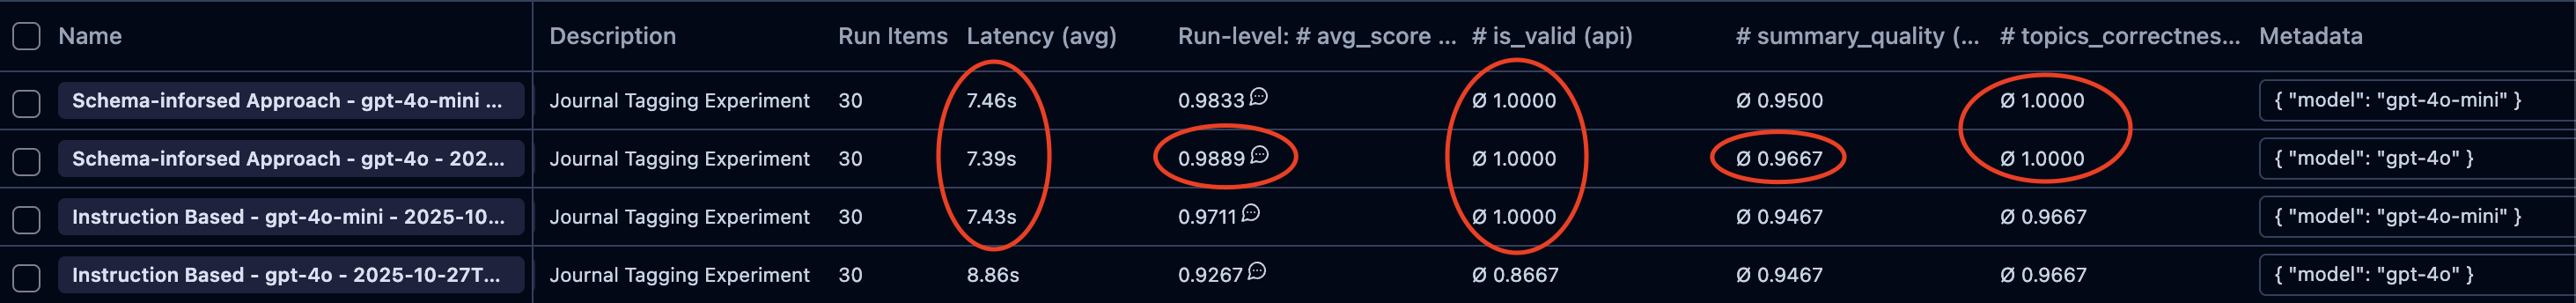

### Multiple Run Results
Of course, I cannot just belive scores of one run. So, I decided to run experiments 4 more times (5 in total) to see how stable results are. And here is the table with averages for all 5 runs.

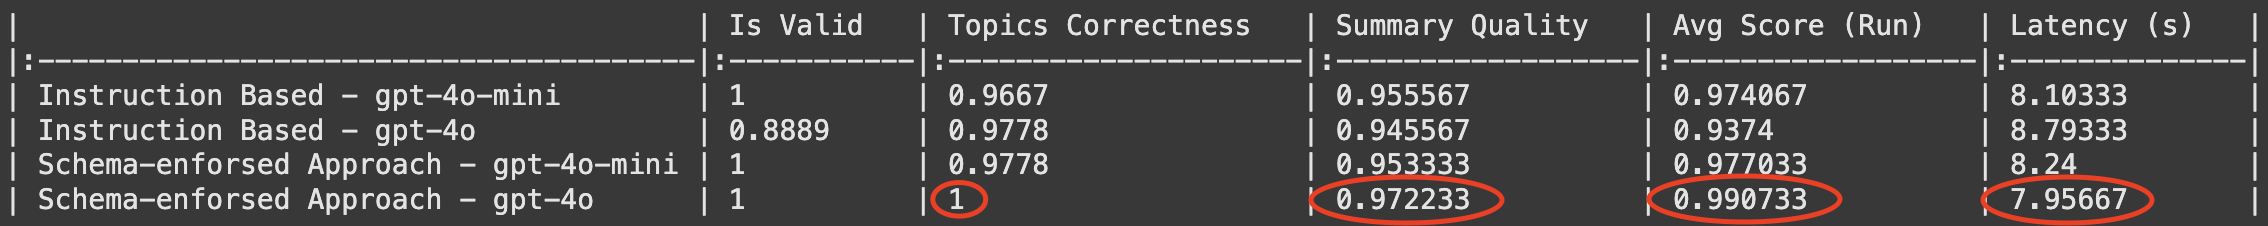

Findings from averaged results:

1. Clear Winner: Schema-enforced Approach with `gpt-4o`.

It scored #1 in every single category. It delivered perfect scores for JSON validity and summary quality, achieved the best topic correctness, and also fastest average latency.

2. Clear Loser: Instruction-based with `gpt-4o`.

This variant was the worst performer in almost every category.
The most powerful model performed poorly when given a simple instruction-based prompt...

3. The "Good Enough" Contenders (`-mini` models).

Schema-enforced with `gpt-4o-mini` is a very strong and reliable runner-up. It had perfect JSON validity, very high topic correctness, and good summary quality. A great alternative to the `gpt-4o`. Instruction-based with `gpt-4o-mini` achieved perfect JSON validity, but had the lowest topic correctness score.

# Takeaways

So, what did I learn from all this? Here are some takeaways:
- **Prompting strategy matters:** In my experiment, the prompting strategy often had a bigger impact on reliability than the raw capability of the model. The results clearly showed that with the right strategy (schema-enforced), even the `gpt-4o-mini` model performed exceptionally well, while the more powerful `gpt-4o` struggled with the simpler instruction-based approach.
- **Experimentation is worth it:** The results weren't always predictable. The most surprising insight was that the instruction-based `gpt-4o-mini` achieved a perfect `is_valid` score, while the supposedly more powerful instruction-based - `gpt-4o` failed on format ~10% of the time with the same prompt.
- **Areas for improvement:** The evaluation process also pinpointed specific areas for the next iteration. For instance, the `summary_quality` judge's prompt needs to be refined. Also, the instruction-based approach needs more work (*I was really betting on that one to be a winner!*).


Anyway, that's it for this guide. Thanks for reading ❤️

The full code for experimental setup for this article can be found in my GitHub repository: https://github.com/MarimoM/experiments-journaling

Feel free to ask if you have any questions!